# Analysis of 3k T cells from cancer

In [1]:
# This cell is for development only. Don't copy this to your notebook.
%load_ext autoreload
%autoreload 2

# Temporarily suppress FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/

In [3]:
sc.logging.print_header()

scanpy==1.9.3 anndata==0.9.0rc2.dev16+g2712af6 umap==0.5.2 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.5


## Importing data

In [4]:
mdata = ir.datasets.wu2020_3k()

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(


In [5]:
mdata

MuData object with n_obs × n_vars = 3000 × 30727
  2 modalities
    gex:	3000 x 30727
      obs:	'cluster_orig', 'patient', 'sample', 'source'
      uns:	'cluster_orig_colors'
      obsm:	'X_umap_orig'
    airr:	3000 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig'
      obsm:	'airr'

## Preprocessing Transcriptomics data

Gene expression (GEX) data needs to be filtered and preprocessed as with any other single-cell dataset.
For this tutorial, we perform minimal preprocessing for demonstration purposes. For a real dataset, we recommend following the [scverse tutorials](https://scverse.org/learn/)
and the [single-cell best practice book](https://sc-best-practices.org/).

In [6]:
sc.pp.filter_genes(mdata["gex"], min_cells=10)
sc.pp.filter_cells(mdata["gex"], min_genes=100)

filtered out 18877 genes that are detected in less than 10 cells


In [7]:
sc.pp.normalize_per_cell(mdata["gex"])
sc.pp.log1p(mdata["gex"])
sc.pp.highly_variable_genes(mdata["gex"], flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(mdata["gex"])
sc.pp.neighbors(mdata["gex"])

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03)


For the _Wu2020_ dataset, the authors already provide clusters and UMAP coordinates.
Instead of performing clustering and cluster annotation ourselves, we will just use
the provided data. The clustering and annotation methodology is
described in [their paper](https://doi.org/10.1038/s41586-020-2056-8).

In [8]:
mdata["gex"].obsm["X_umap"] = mdata["gex"].obsm["X_umap_orig"]

In [9]:
mapping = {
    "nan": "other",
    "3.1-MT": "other",
    "4.1-Trm": "CD4_Trm",
    "4.2-RPL32": "CD4_RPL32",
    "4.3-TCF7": "CD4_TCF7",
    "4.4-FOS": "CD4_FOSS",
    "4.5-IL6ST": "CD4_IL6ST",
    "4.6a-Treg": "CD4_Treg",
    "4.6b-Treg": "CD4_Treg",
    "8.1-Teff": "CD8_Teff",
    "8.2-Tem": "CD8_Tem",
    "8.3a-Trm": "CD8_Trm",
    "8.3b-Trm": "CD8_Trm",
    "8.3c-Trm": "CD8_Trm",
    "8.4-Chrom": "other",
    "8.5-Mitosis": "other",
    "8.6-KLRB1": "other",
}
mdata["gex"].obs["cluster"] = mdata["gex"].obs["cluster_orig"].map(mapping)

Now that we filtered obs and var of the GEX modality, we need to propagate those changes back to the `MuData` object.

In [10]:
mdata.update()

Let's inspect the UMAP plots. The first three panels show the UMAP plot colored by sample, patient and cluster.
We don't observe any obvious clustering of samples or patients that could hint at batch effects.

The last three panels show the UMAP colored by the T cell markers _CD8_, _CD4_, and _FOXP3_.
We can confirm that the markers correspond to their respective cluster labels.

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


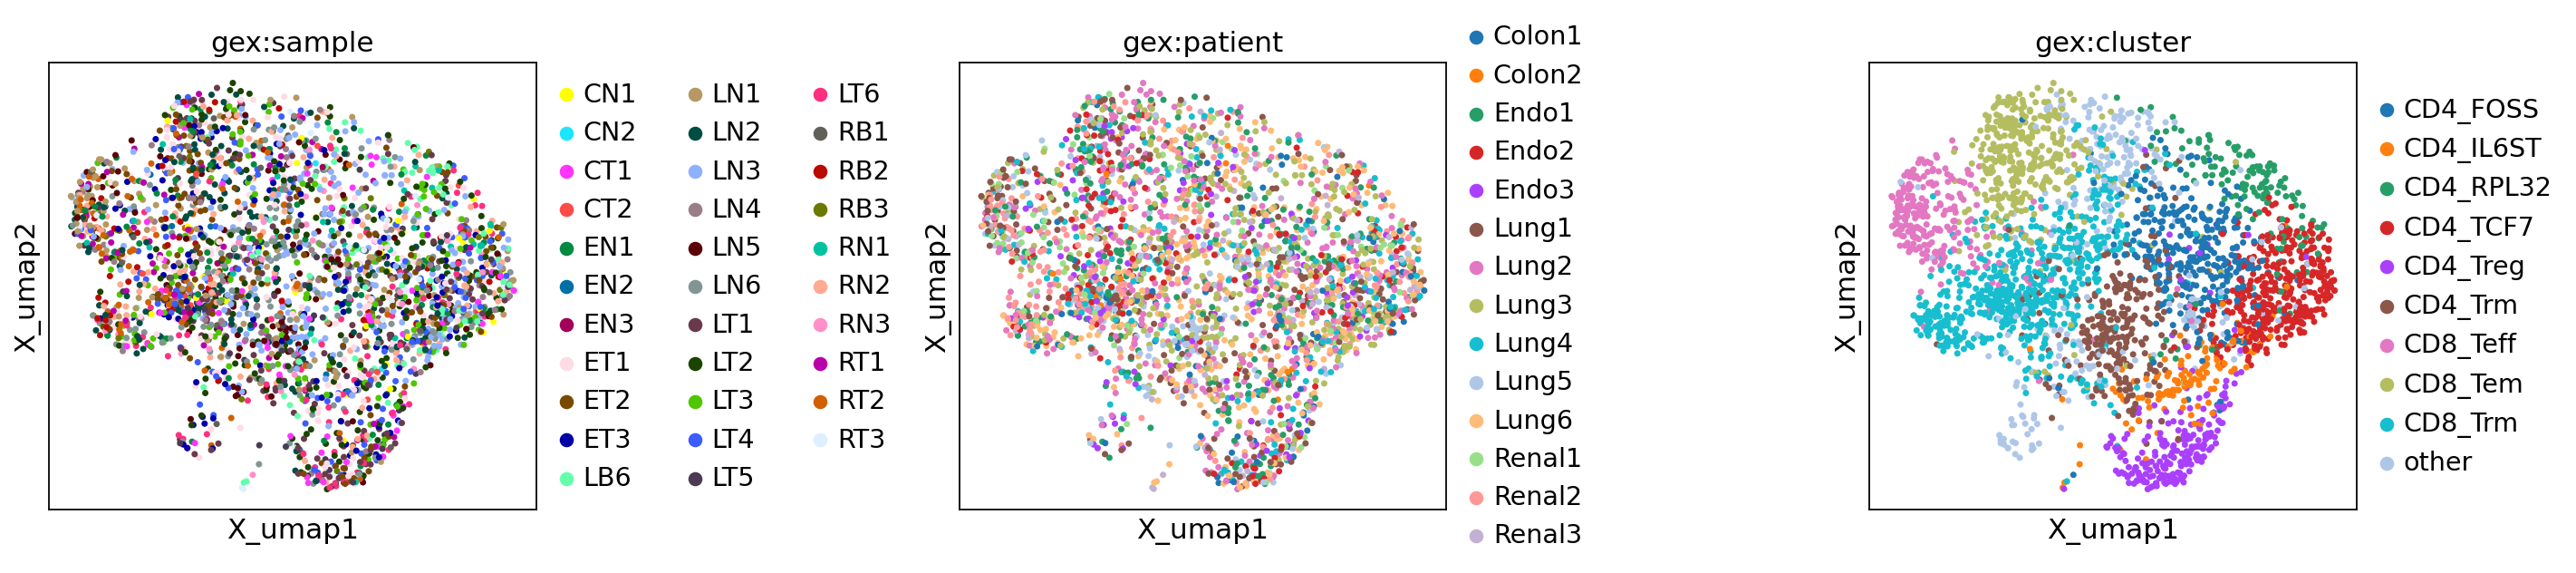

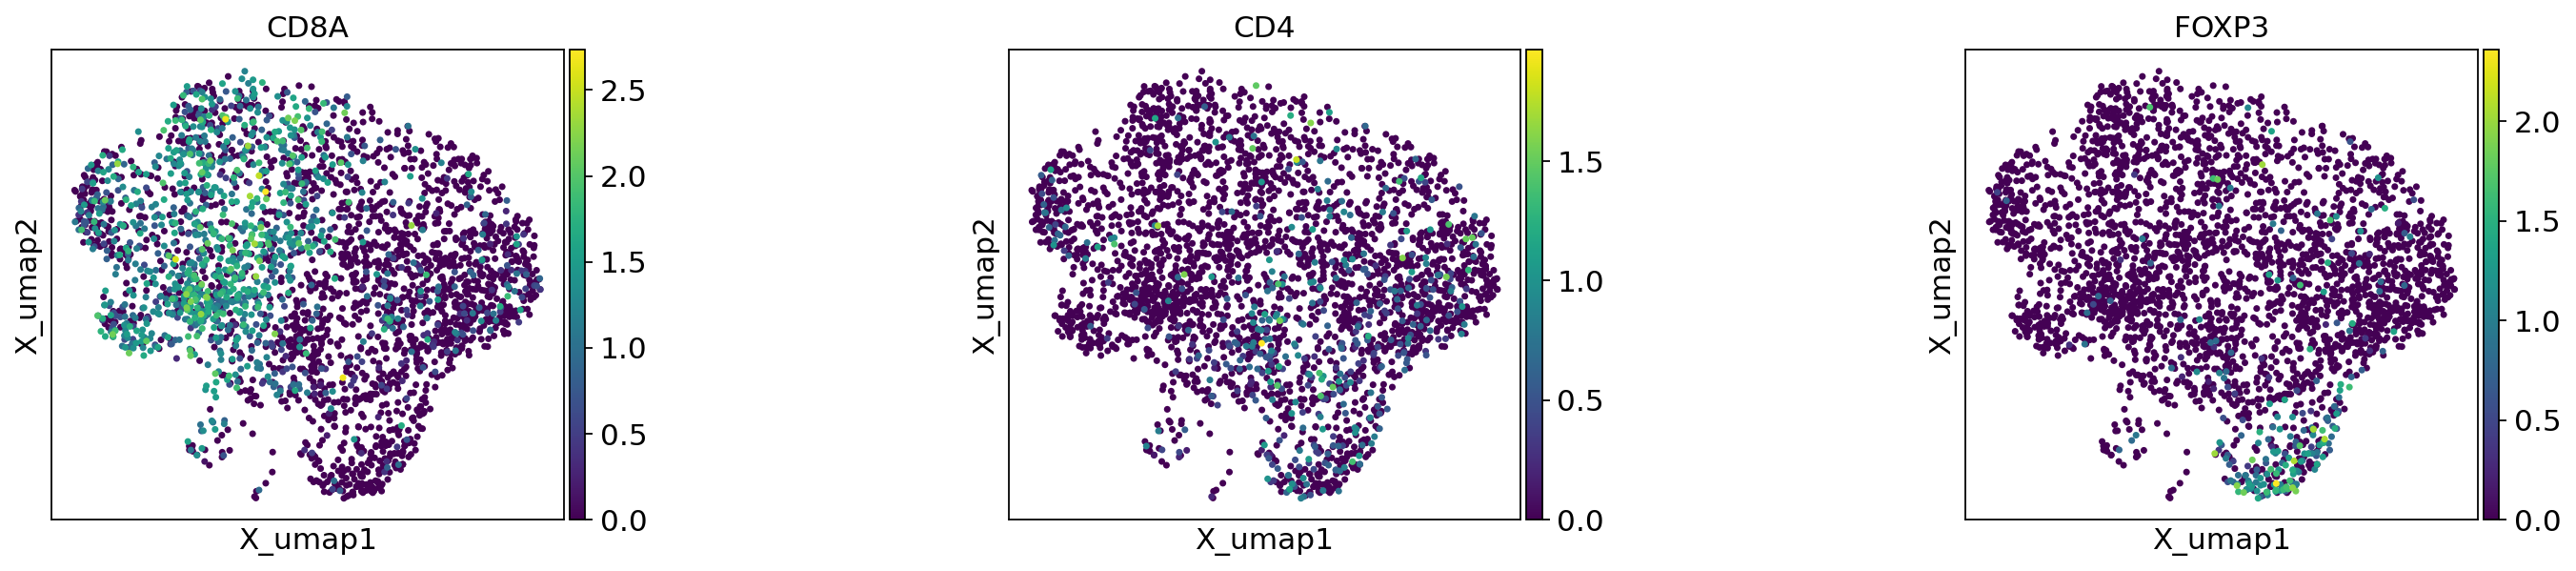

In [11]:
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["gex:sample", "gex:patient", "gex:cluster"],
    ncols=3,
    wspace=0.7,
)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["CD8A", "CD4", "FOXP3"],
    ncols=3,
    wspace=0.7,
)

## Creating chain indices

In [12]:
ir.pp.index_chains(mdata)

  0%|          | 0/1 [00:00<?, ?it/s]

## TCR Quality Control

In [13]:
ir.tl.chain_qc(mdata)

Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


As expected, the dataset contains only α/β T-cell receptors:

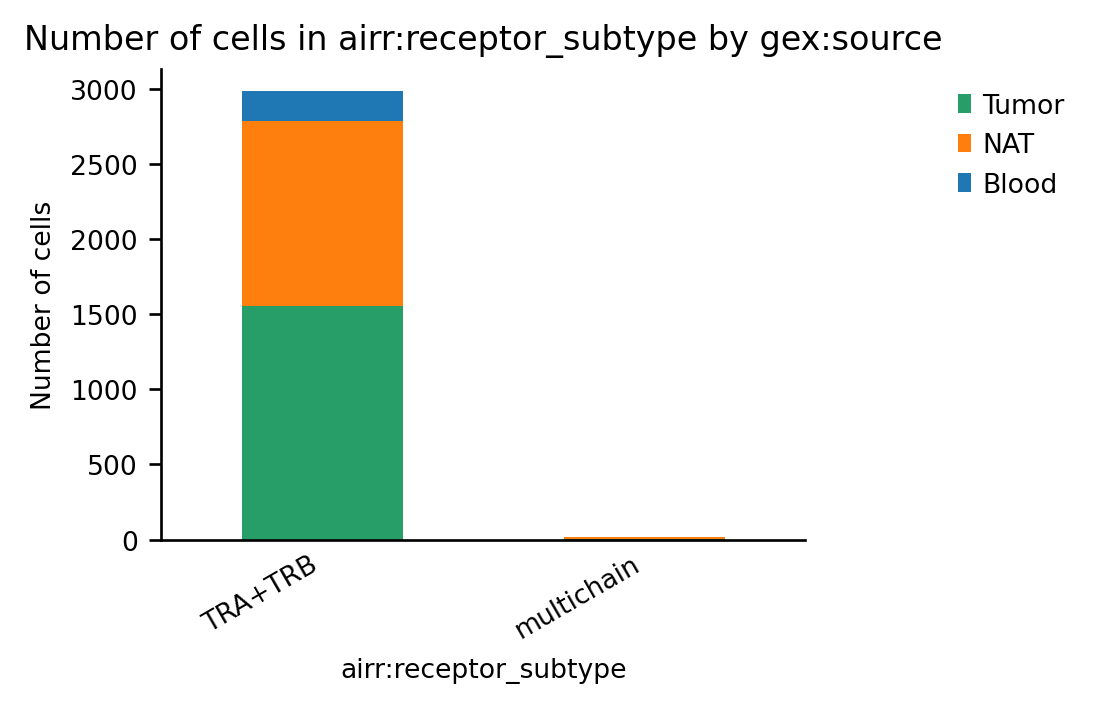

In [14]:
_ = ir.pl.group_abundance(
    mdata, groupby="airr:receptor_subtype", target_col="gex:source"
)

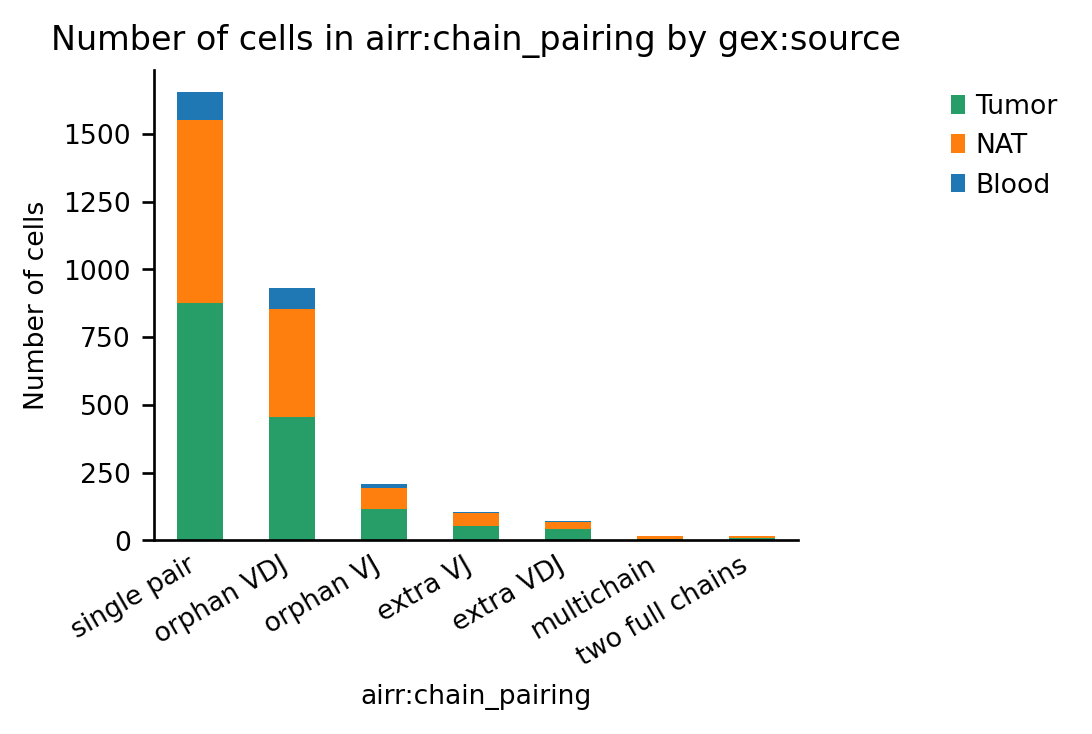

In [15]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:source")

Indeed, in this dataset, ~7% of cells have more than
one pair of productive T-cell receptors:

In [16]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            mdata.obs["airr:chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains", "multichain"]
            )
        )
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.07


/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


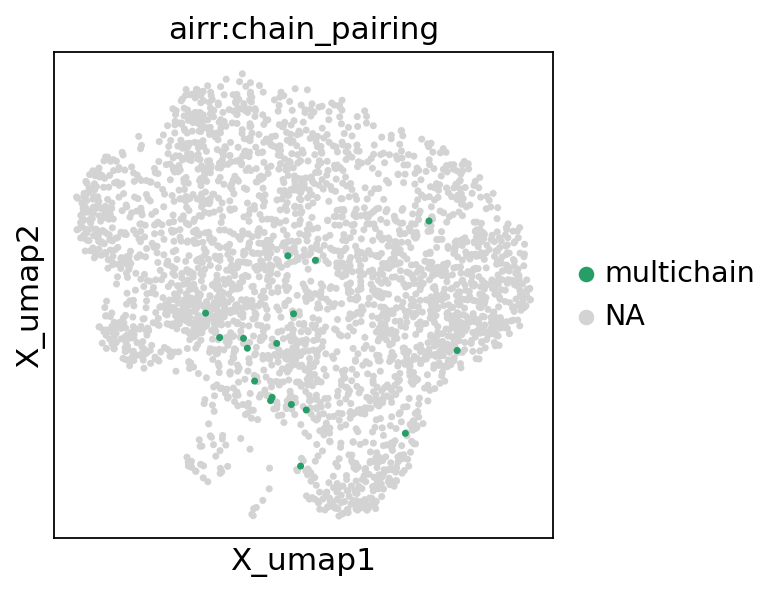

In [17]:
mu.pl.embedding(
    mdata, basis="gex:umap", color="airr:chain_pairing", groups="multichain"
)

In [18]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: x != "multichain")

Similarly, we can use the `chain_pairing` information to exclude all cells that don't have at least
one full pair of receptor sequences:

In [19]:
mu.pp.filter_obs(
    mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"])
)

In [20]:
mdata

MuData object with n_obs × n_vars = 1845 × 11850
  2 modalities
    gex:	1845 x 11850
      obs:	'cluster_orig', 'patient', 'sample', 'source', 'n_genes', 'n_counts', 'cluster'
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'cluster_orig_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'gex:sample_colors', 'gex:patient_colors', 'gex:cluster_colors', 'airr:chain_pairing_colors'
      obsm:	'X_umap_orig', 'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	1845 x 0
      obs:	'high_confidence', 'is_cell', 'clonotype_orig', 'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

Finally, we re-create the chain-pairing plot to ensure that the filtering worked
as expected:

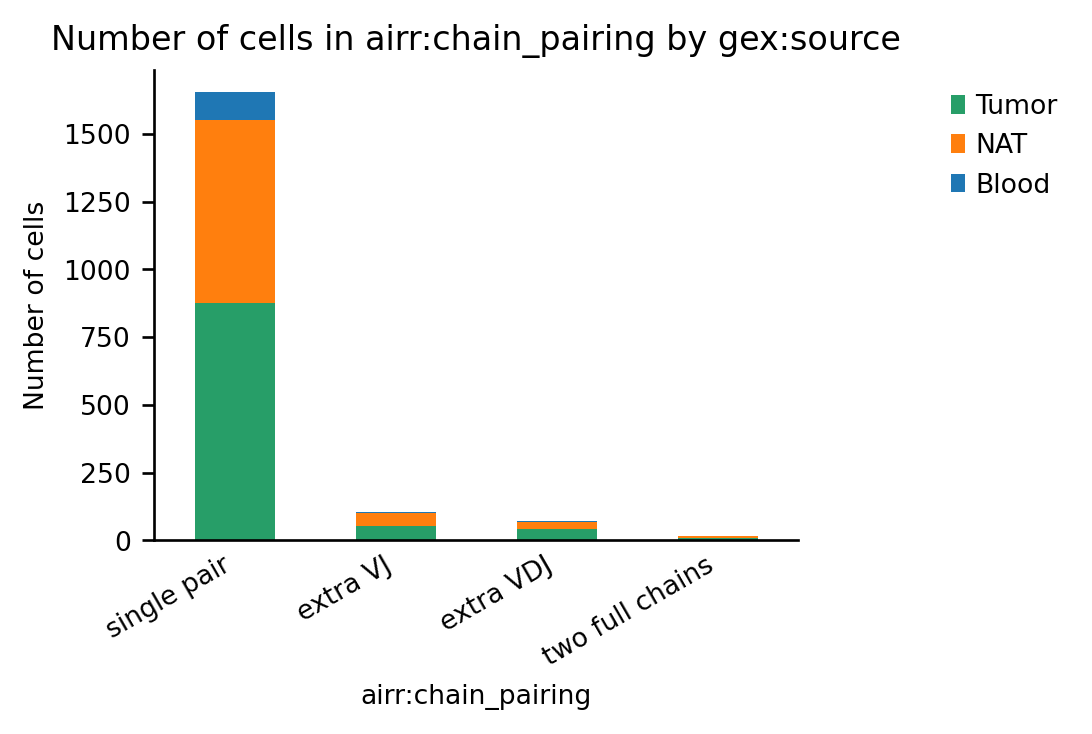

In [21]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="gex:source")

## Define clonotypes and clonotype clusters

### Compute CDR3 neighborhood graph and define clonotypes

In [22]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/1526 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:clone_id"]`.
Stored result in `mdata.obs["airr:clone_id_size"]`.


In [23]:
ir.tl.clonotype_network(mdata, min_cells=2)

In [24]:
mdata.obs.groupby("gex:source", dropna=False).size()

gex:source
Blood    107
NAT      756
Tumor    982
dtype: int64

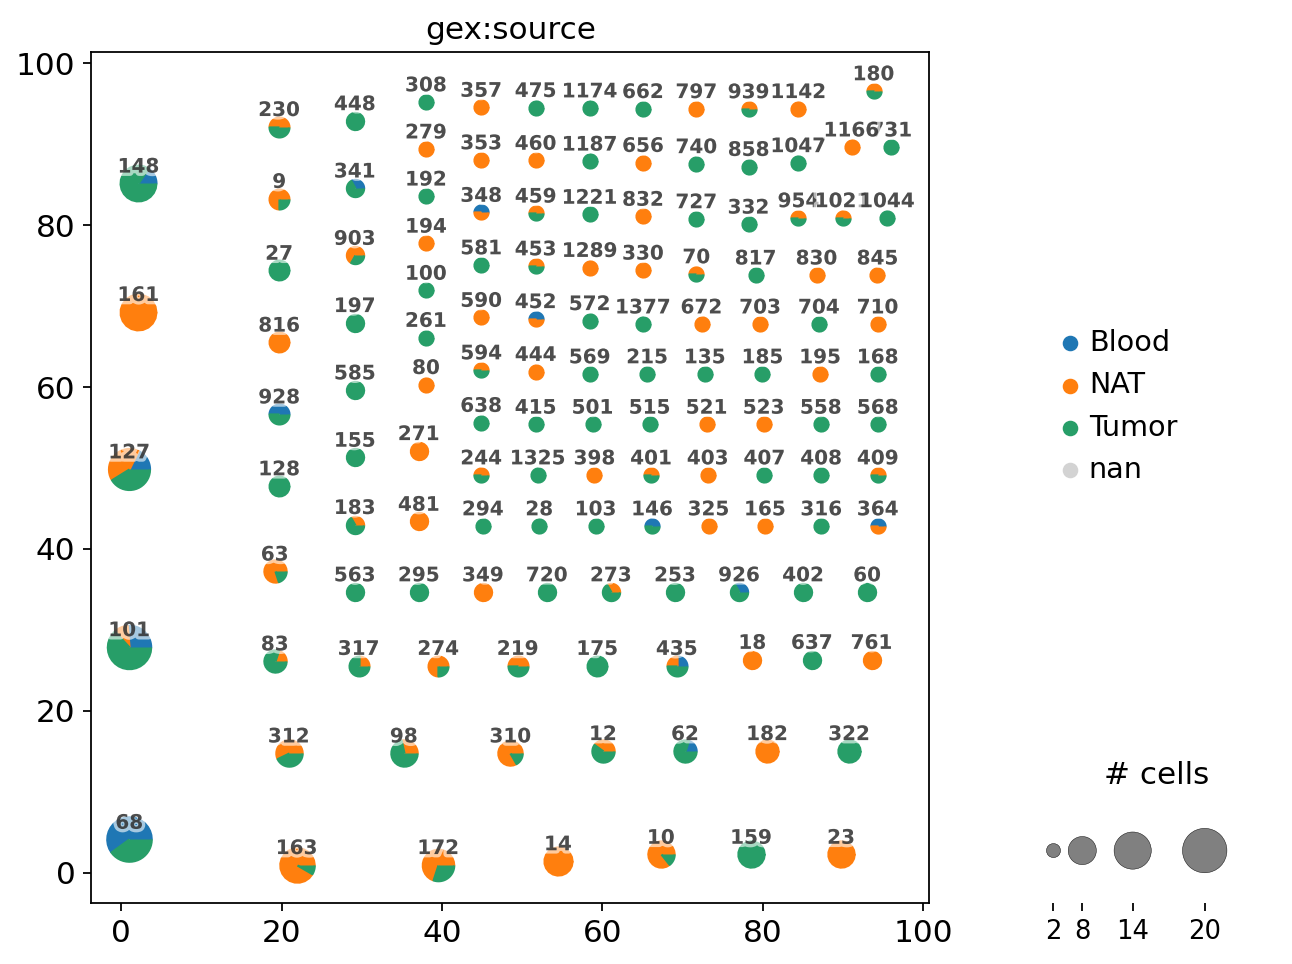

In [25]:
_ = ir.pl.clonotype_network(
    mdata, color="gex:source", base_size=20, label_fontsize=9, panel_size=(7, 7)
)

### Re-compute CDR3 neighborhood graph and define clonotype clusters

In [26]:
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

Computing sequence x sequence distance matrix for VJ sequences.


  0%|          | 0/496 [00:00<?, ?it/s]

Computing sequence x sequence distance matrix for VDJ sequences.


  0%|          | 0/496 [00:00<?, ?it/s]

In [27]:
ir.tl.define_clonotype_clusters(
    mdata, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/1549 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:cc_aa_alignment"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_size"]`.


In [28]:
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="alignment")

Compared to the previous plot, we observere several connected dots.
Each fully connected subnetwork represents a "clonotype cluster", each dot
still represents cells with identical receptor configurations.

The dots are colored by patient. We observe, that for instance, clonotypes `101` and `68` (left top and bottom) are _private_, i.e. they contain cells from a single patient only. On the other hand, clonotype `159` (left middle) is
_public_, i.e. it is shared across patients _Lung1_ and _Lung3_.

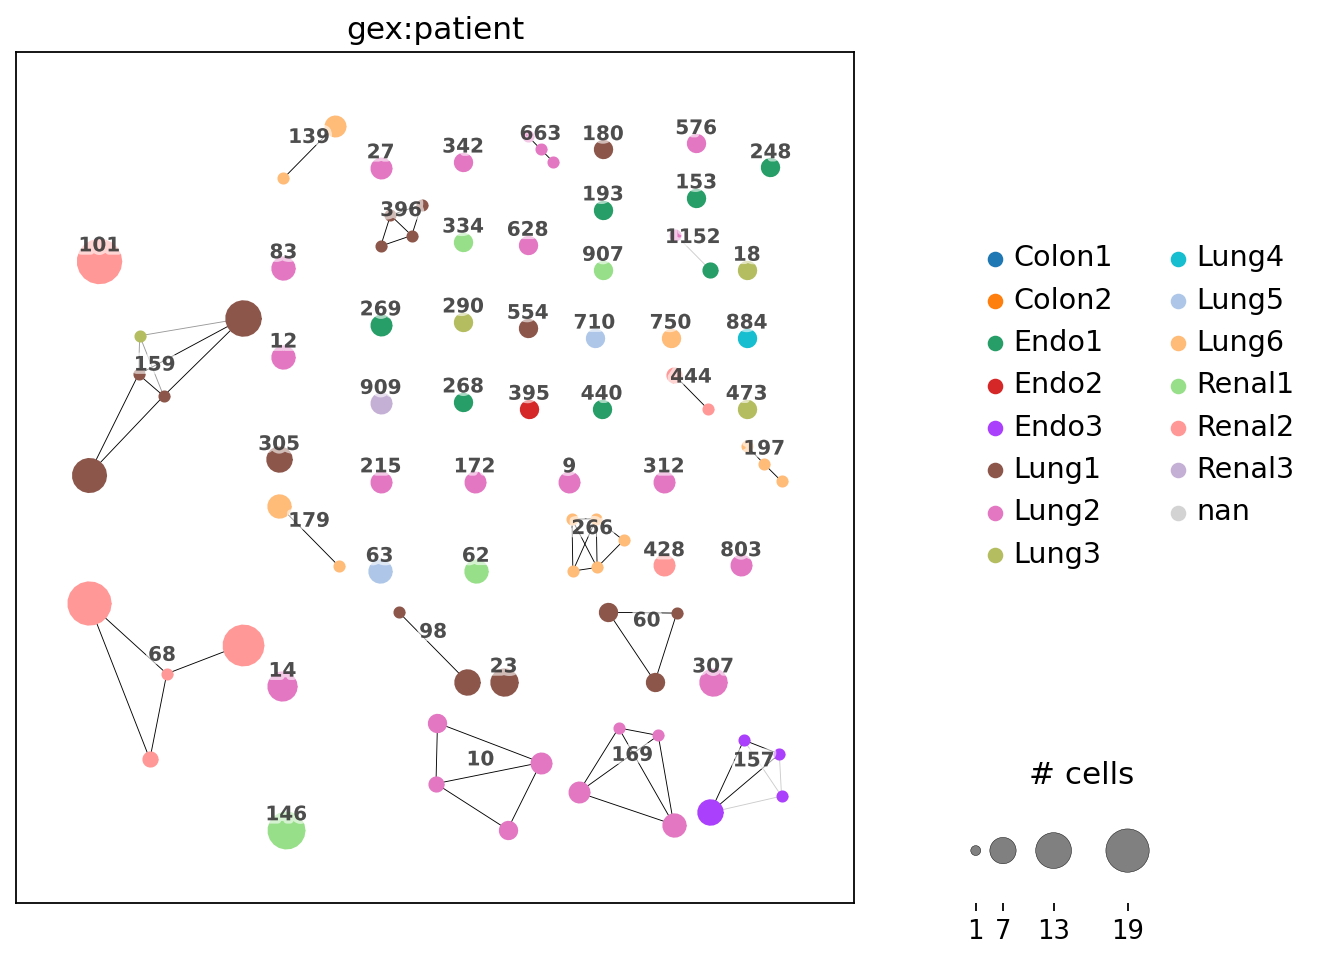

In [29]:
_ = ir.pl.clonotype_network(
    mdata, color="gex:patient", label_fontsize=9, panel_size=(7, 7), base_size=20
)

In [30]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    cdr3_ct_159 = (
        # TODO astype(str) is required due to a bug in pandas ignoring `dropna=False`. It seems fixed in pandas 2.x
        mdata.obs.loc[lambda x: x["airr:cc_aa_alignment"] == "159"]
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
cdr3_ct_159

VJ_1_junction_aa VDJ_1_junction_aa VJ_2_junction_aa VDJ_2_junction_aa  \
0    CAGKAGNTGKLIF     CASSYQGSTEAFF              nan               nan   
1    CAGKSGNTGKLIF     CASSYQGATEAFF  CATDPRRSTGNQFYF               nan   
2    CAGKSGNTGKLIF     CASSYQGATEAFF              nan               nan   
3  CATDPRRSTGNQFYF     CASSYQGATEAFF    CAGKSGNTGKLIF               nan   
4  CATDPRRSTGNQFYF     CASSYQGATEAFF              nan               nan   

  airr:receptor_subtype  n_cells  
0               TRA+TRB        1  
1               TRA+TRB        1  
2               TRA+TRB       12  
3               TRA+TRB        1  
4               TRA+TRB       11

### Including the V-gene in clonotype definition

In [31]:
ir.tl.define_clonotype_clusters(
    mdata,
    sequence="aa",
    metric="alignment",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    key_added="cc_aa_alignment_same_v",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/1549 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:cc_aa_alignment_same_v"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_same_v_size"]`.


In [32]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = mdata.obs.groupby("airr:cc_aa_alignment").apply(
    lambda x: x["airr:cc_aa_alignment_same_v"].nunique() > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values.tolist()
ct_different_v

['280', '765']

Here, we see that the clonotype clusters `280` and `765` get split into `(280, 788)` and `(765, 1071)`, respectively, when the `same_v_gene` flag is set.

In [33]:
with ir.get.airr_context(mdata, "v_call", ["VJ_1", "VDJ_1"]):
    ct_different_v_df = (
        mdata.obs.loc[
            lambda x: x["airr:cc_aa_alignment"].isin(ct_different_v),
            [
                "airr:cc_aa_alignment",
                "airr:cc_aa_alignment_same_v",
                "VJ_1_v_call",
                "VDJ_1_v_call",
            ],
        ]
        .sort_values("airr:cc_aa_alignment")
        .drop_duplicates()
        .reset_index(drop=True)
    )
ct_different_v_df

airr:cc_aa_alignment airr:cc_aa_alignment_same_v VJ_1_v_call VDJ_1_v_call
0                  280                         280     TRAV8-6      TRBV6-6
1                  280                         788     TRAV8-3        TRBV9
2                  765                         765      TRAV21      TRBV6-6
3                  765                        1071      TRAV21      TRBV6-5

## Clonotype analysis

### Clonal expansion

In [34]:
ir.tl.clonal_expansion(mdata)

Stored result in `mdata.obs["airr:clonal_expansion"]`.


`clonal_expansion` refers to expansion categories, i.e singleton clonotypes, clonotypes with 2 cells and more than 2 cells.
The `clonotype_size` refers to the absolute number of cells in a clonotype.

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


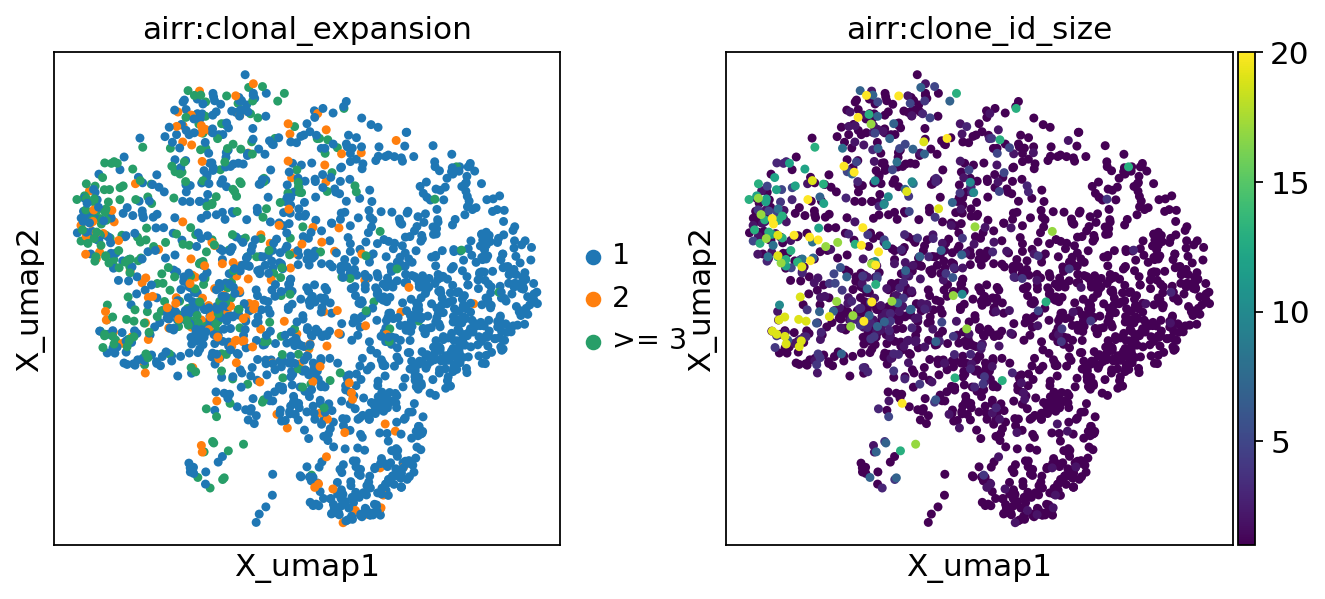

In [35]:
mu.pl.embedding(
    mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"]
)

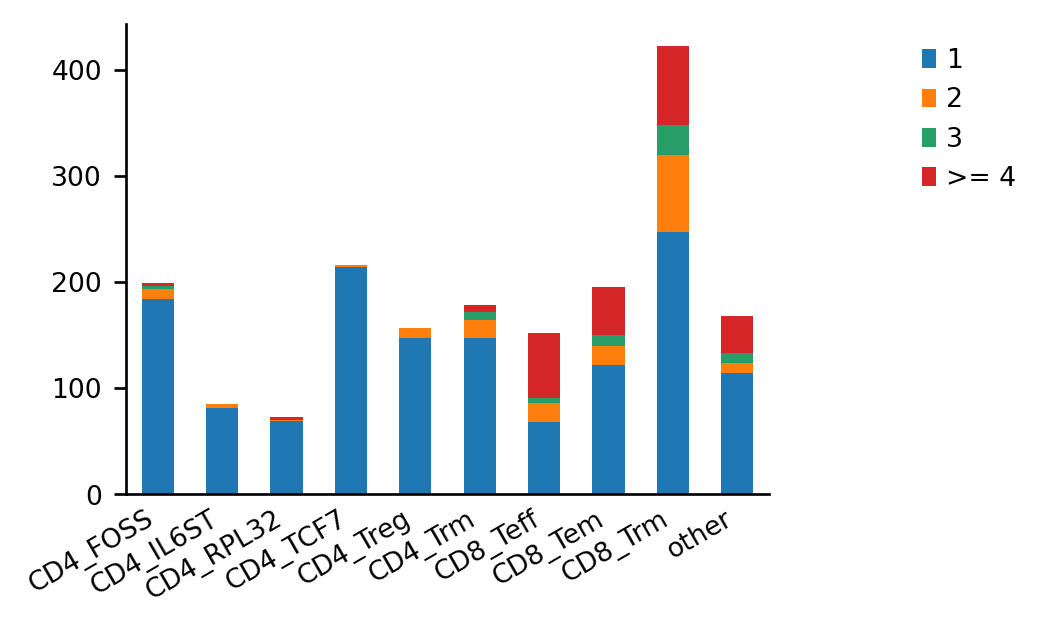

In [36]:
_ = ir.pl.clonal_expansion(
    mdata, target_col="clone_id", groupby="gex:cluster", clip_at=4, normalize=False
)

The same plot, normalized to cluster size. Clonal expansion is a sign of positive selection
for a certain, reactive T-cell clone. It, therefore, makes sense that CD8+ effector T-cells
have the largest fraction of expanded clonotypes.

<Axes: >

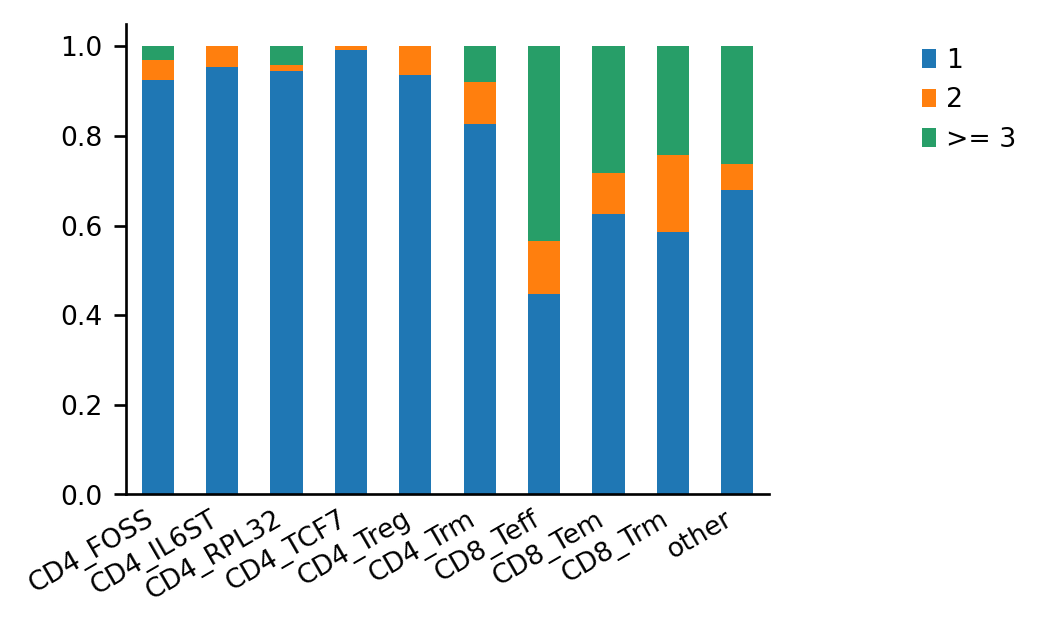

In [37]:
ir.pl.clonal_expansion(mdata, target_col="clone_id", groupby="gex:cluster")

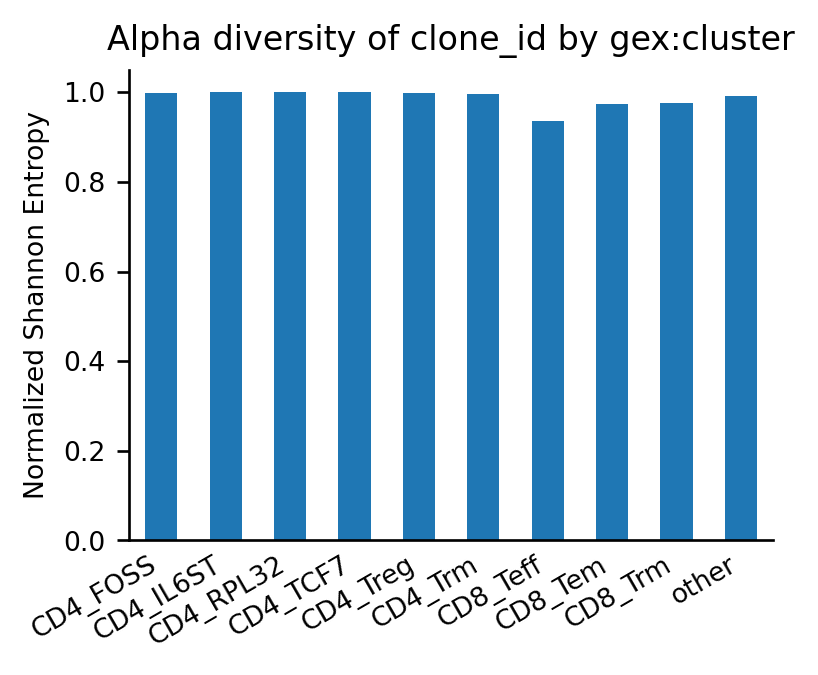

In [38]:
_ = ir.pl.alpha_diversity(
    mdata, metric="normalized_shannon_entropy", groupby="gex:cluster"
)

### Clonotype abundance

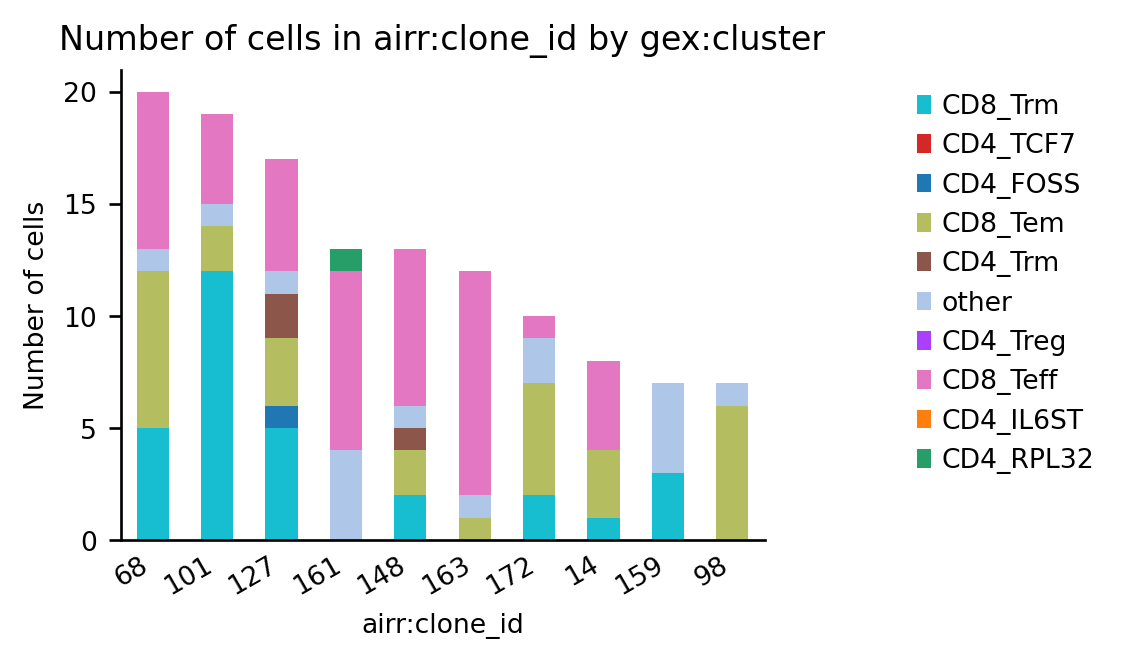

In [39]:
_ = ir.pl.group_abundance(
    mdata, groupby="airr:clone_id", target_col="gex:cluster", max_cols=10
)

It might be beneficial to normalize the counts
to the number of cells per sample to mitigate biases due to different sample sizes:

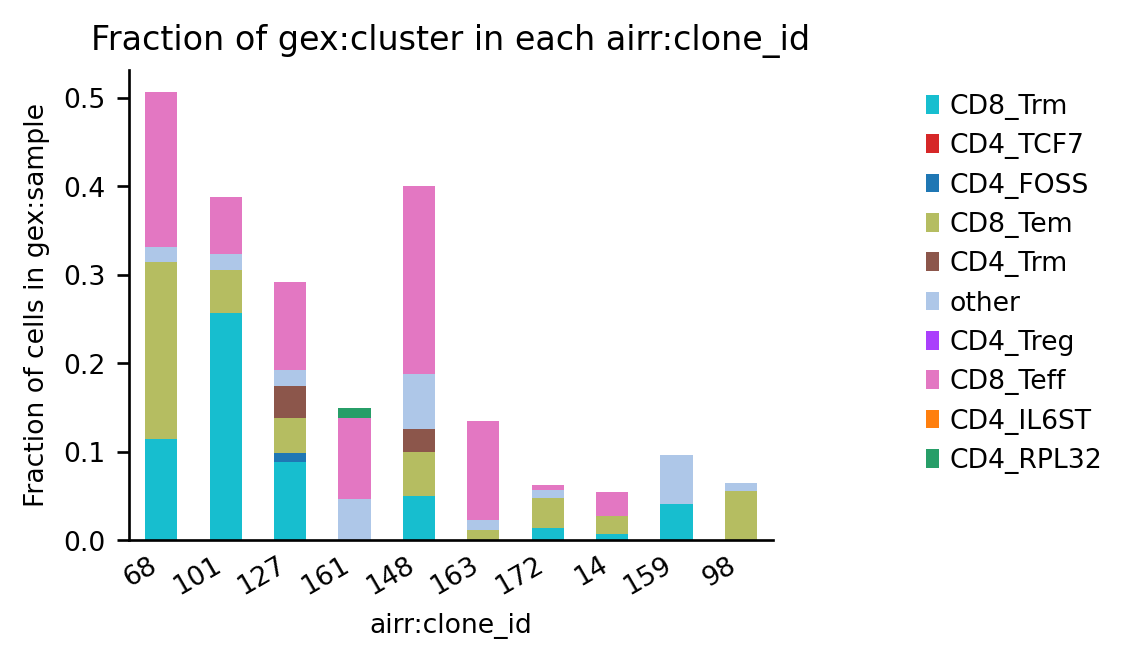

In [40]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:cluster",
    max_cols=10,
    normalize="gex:sample",
)

Coloring the bars by patient gives us information about public and private clonotypes:
Some clonotypes are _private_, i.e. specific to a certain tissue,
others are _public_, i.e. they are shared across different tissues.

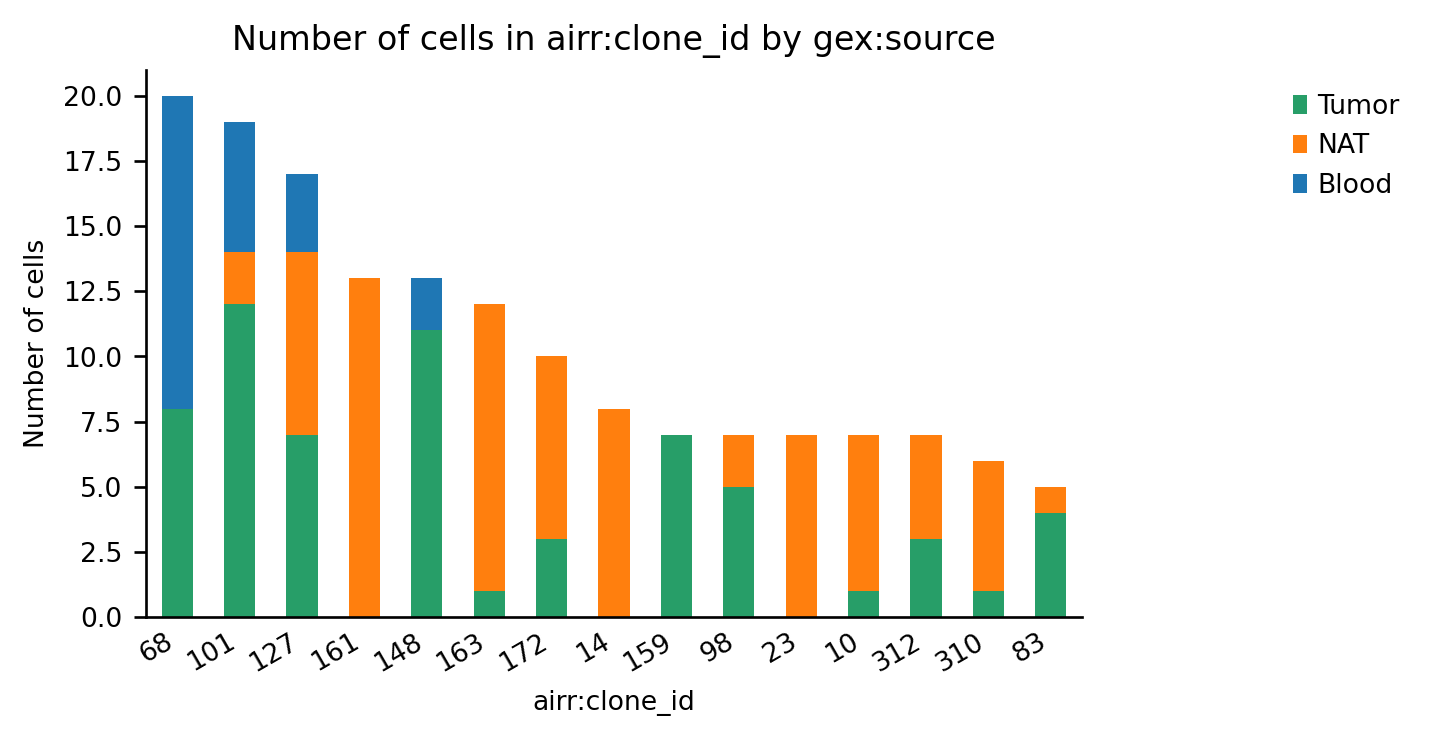

In [41]:
_ = ir.pl.group_abundance(
    mdata, groupby="airr:clone_id", target_col="gex:source", max_cols=15, figsize=(5, 3)
)

However, clonotypes that are shared between _patients_ are rare:

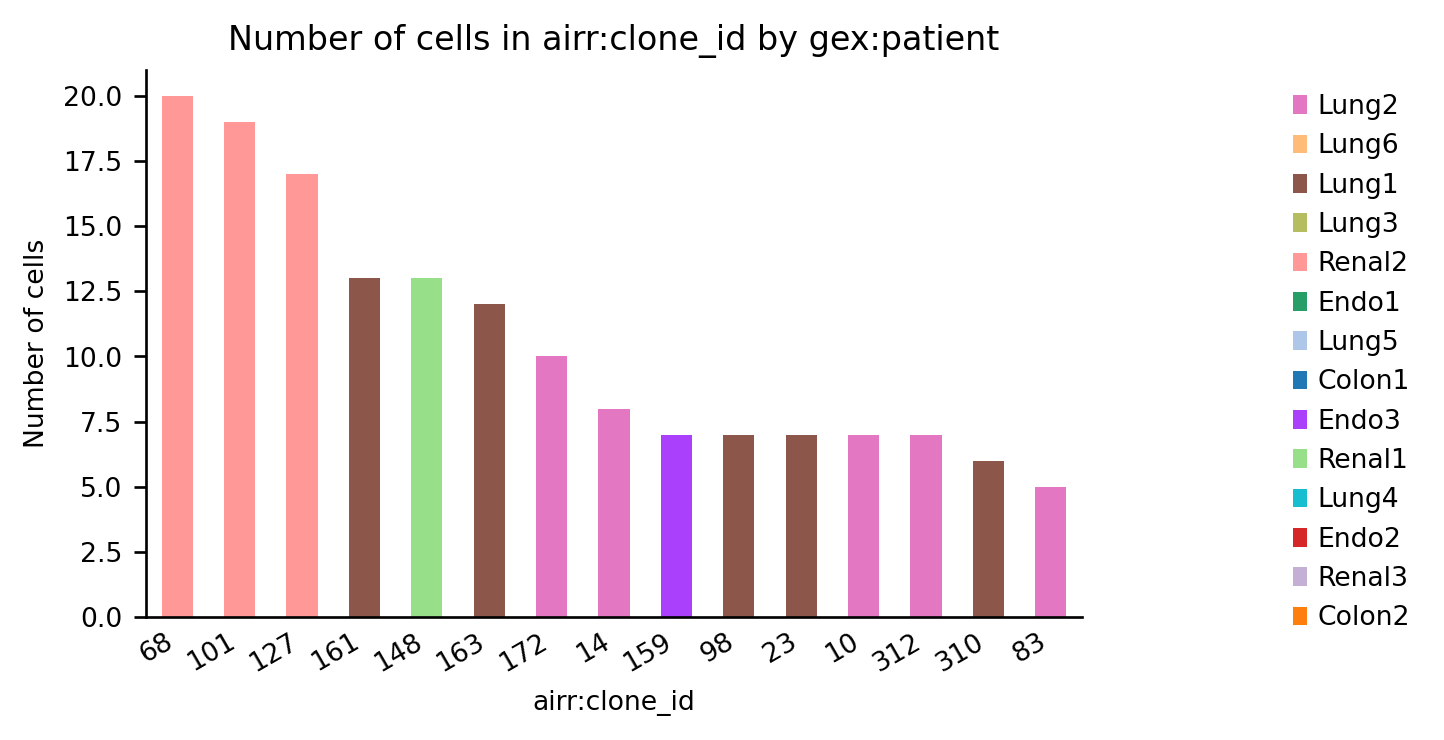

In [42]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="gex:patient",
    max_cols=15,
    figsize=(5, 3),
)

### Convergent evolution

In [43]:
ir.tl.clonotype_convergence(mdata, key_coarse="cc_aa_alignment", key_fine="clone_id")

Stored result in `mdata.obs["airr:is_convergent"]`.


/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


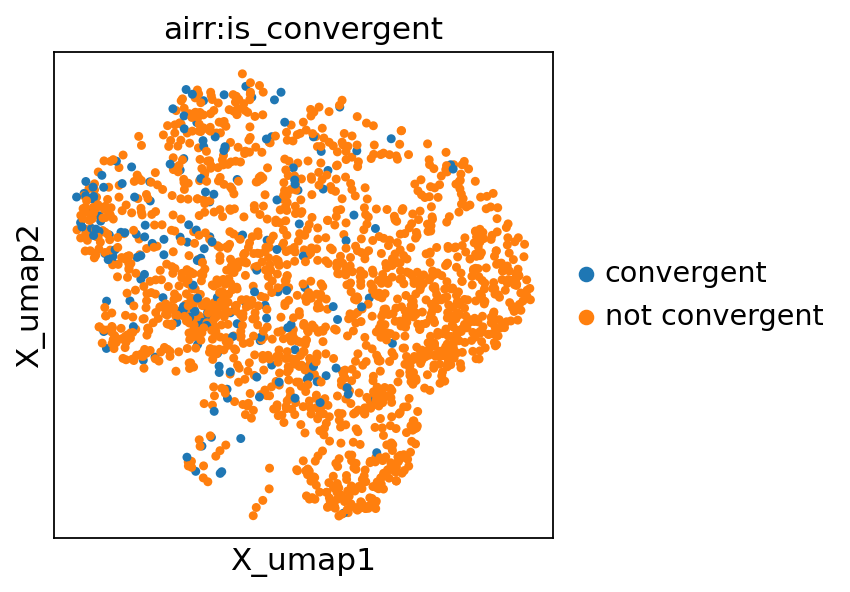

In [44]:
mu.pl.embedding(mdata, "gex:umap", color="airr:is_convergent")

## Gene usage

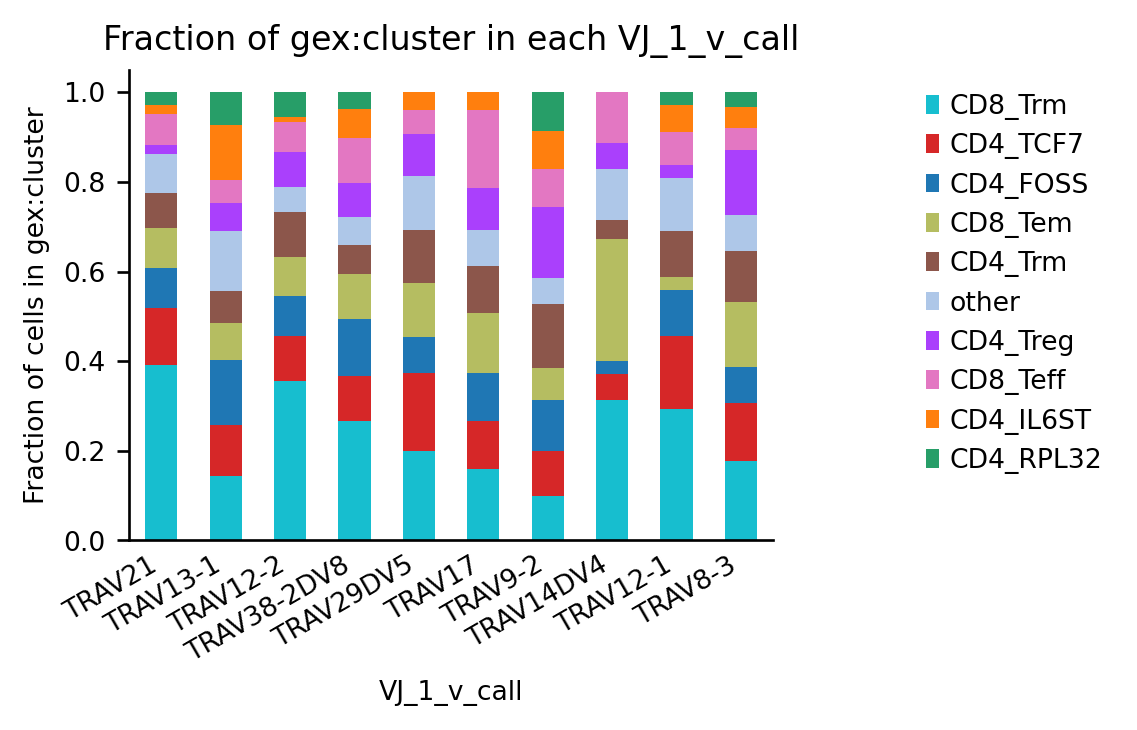

In [45]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata,
        groupby="VJ_1_v_call",
        target_col="gex:cluster",
        normalize=True,
        max_cols=10,
    )

We can pre-select groups by filtering `adata`:

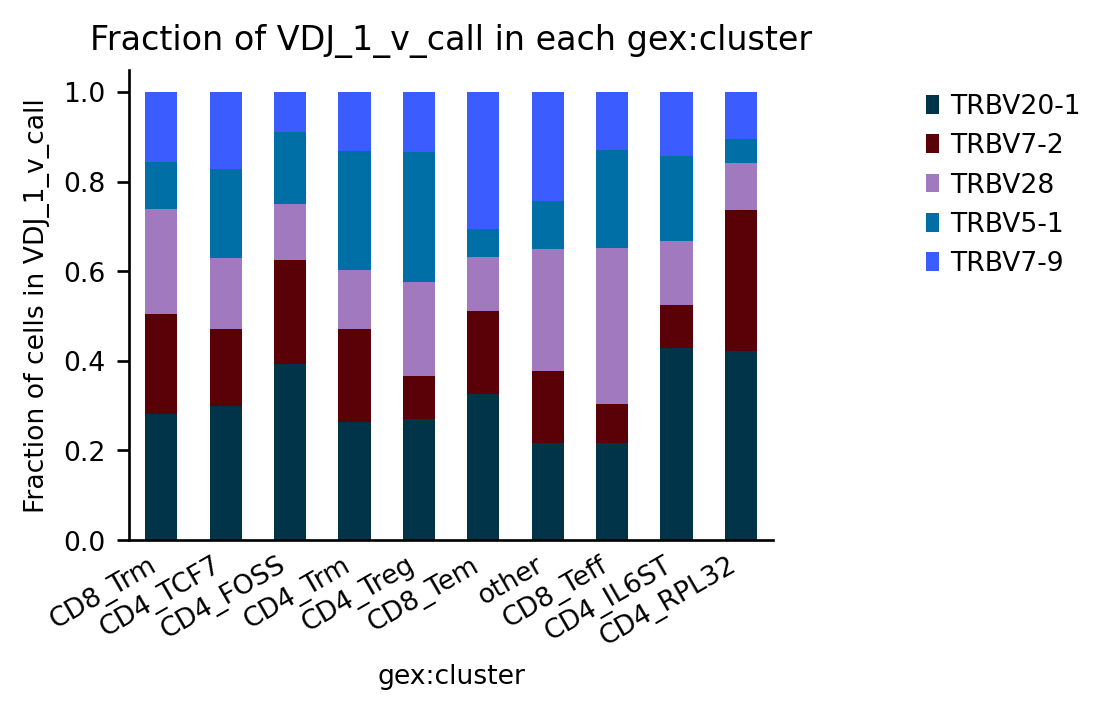

In [46]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.group_abundance(
        mdata[
            mdata.obs["VDJ_1_v_call"].isin(
                ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
            ),
            :,
        ],
        groupby="gex:cluster",
        target_col="VDJ_1_v_call",
        normalize=True,
    )

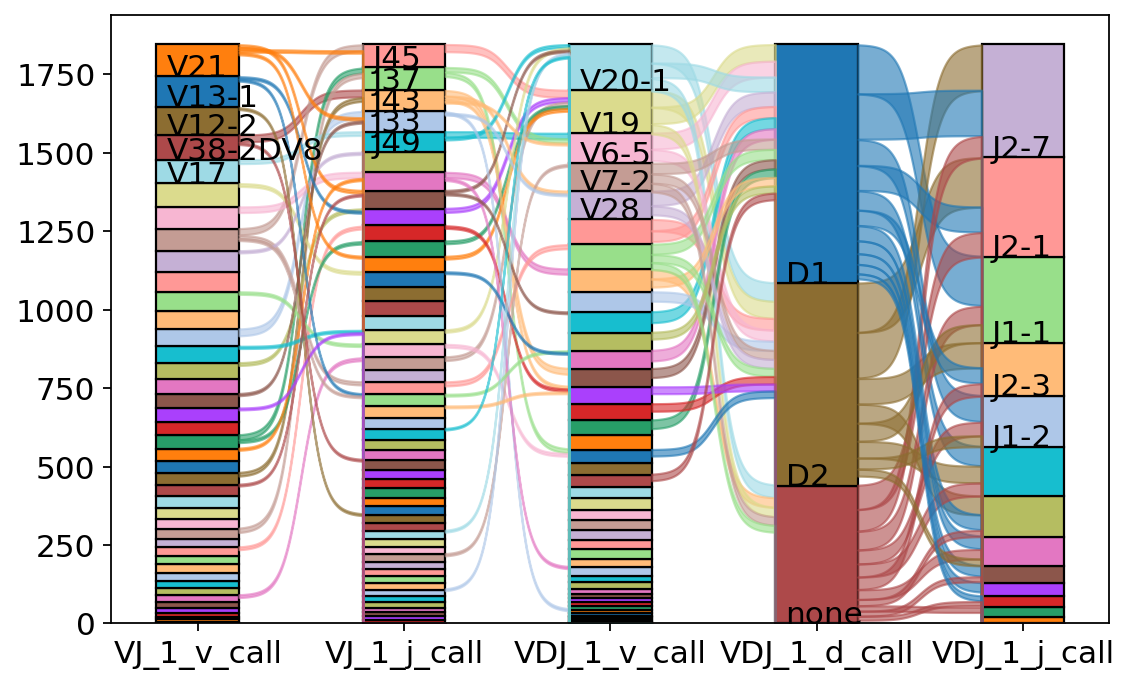

In [47]:
_ = ir.pl.vdj_usage(
    mdata,
    full_combination=False,
    max_segments=None,
    max_ribbons=30,
    fig_kws={"figsize": (8, 5)},
)

We can also use this plot to investigate the exact VDJ composition of one (or several) clonotypes:

<Axes: >

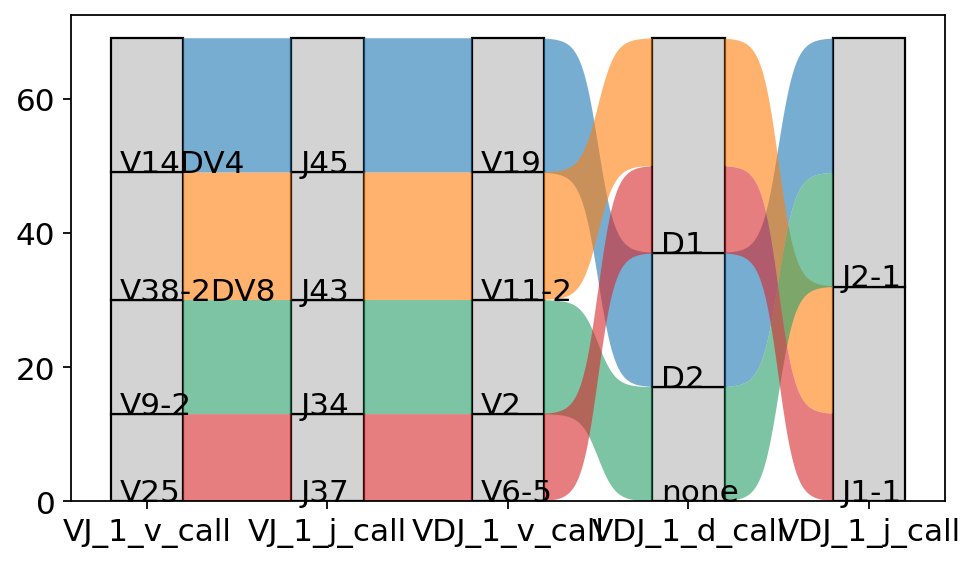

In [48]:
ir.pl.vdj_usage(
    mdata[mdata.obs["airr:clone_id"].isin(["68", "101", "127", "161"]), :],
    max_ribbons=None,
    max_segments=100,
)

### Spectratype plots

<Axes: title={'center': 'Spectratype of junction_aa by gex:cluster'}, xlabel='junction_aa length', ylabel='Number of cells'>

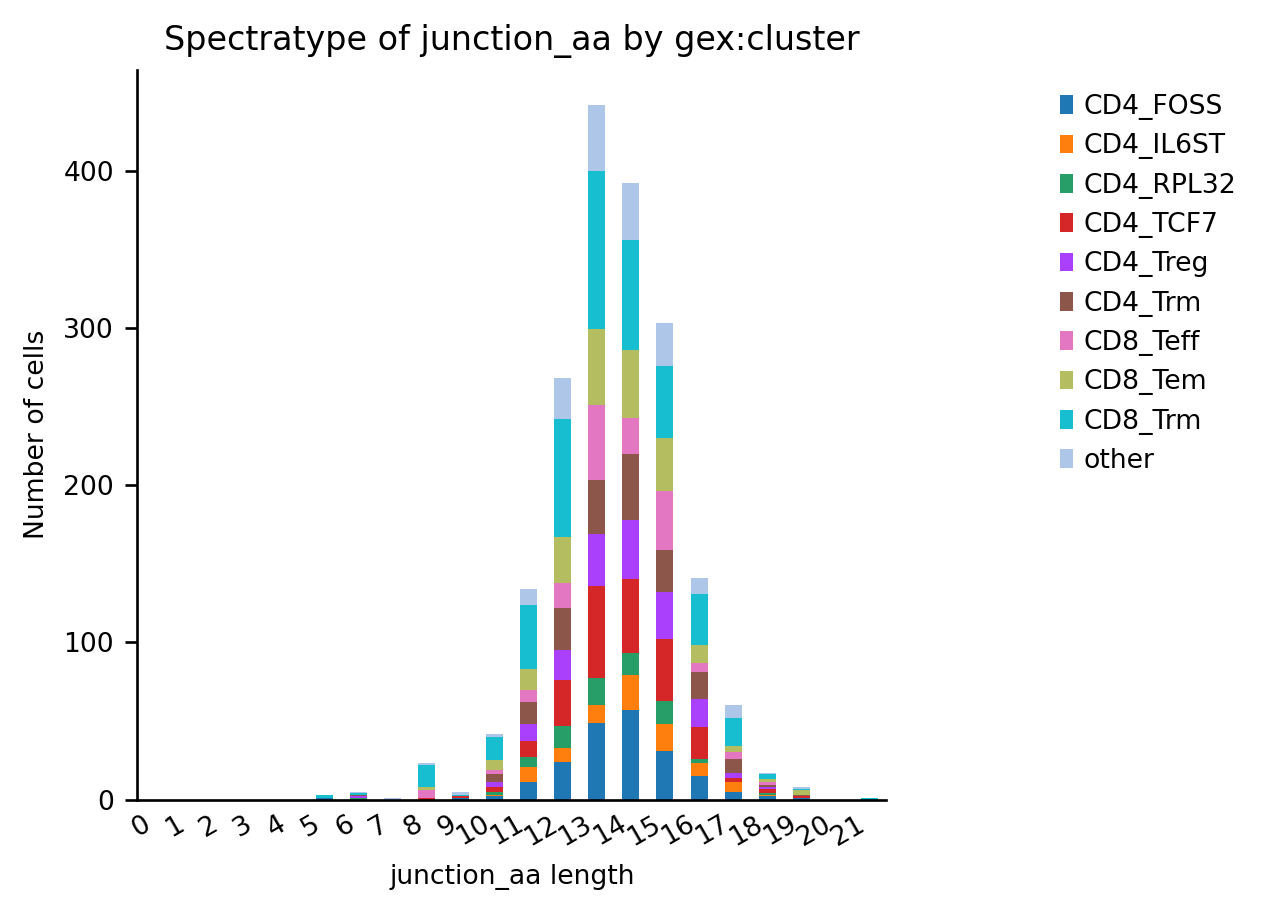

In [49]:
ir.pl.spectratype(mdata, color="gex:cluster", viztype="bar", fig_kws={"dpi": 120})

The same chart visualized as "ridge"-plot:

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scirpy/pl/base.py:262: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<Axes: title={'center': 'Spectratype of junction_aa by gex:cluster'}, xlabel='junction_aa length'>

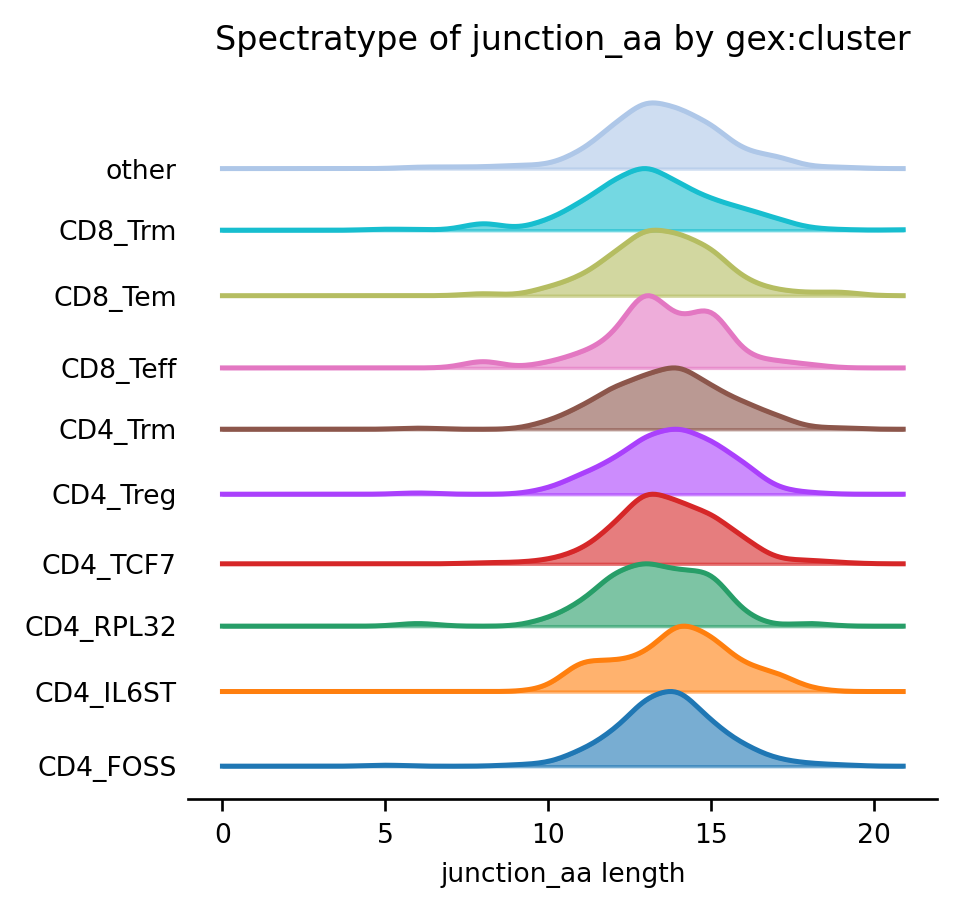

In [50]:
ir.pl.spectratype(
    mdata,
    color="gex:cluster",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": False},
)

A spectratype-plot by gene usage. To pre-select specific genes, we can simply filter the `mdata` object before plotting.

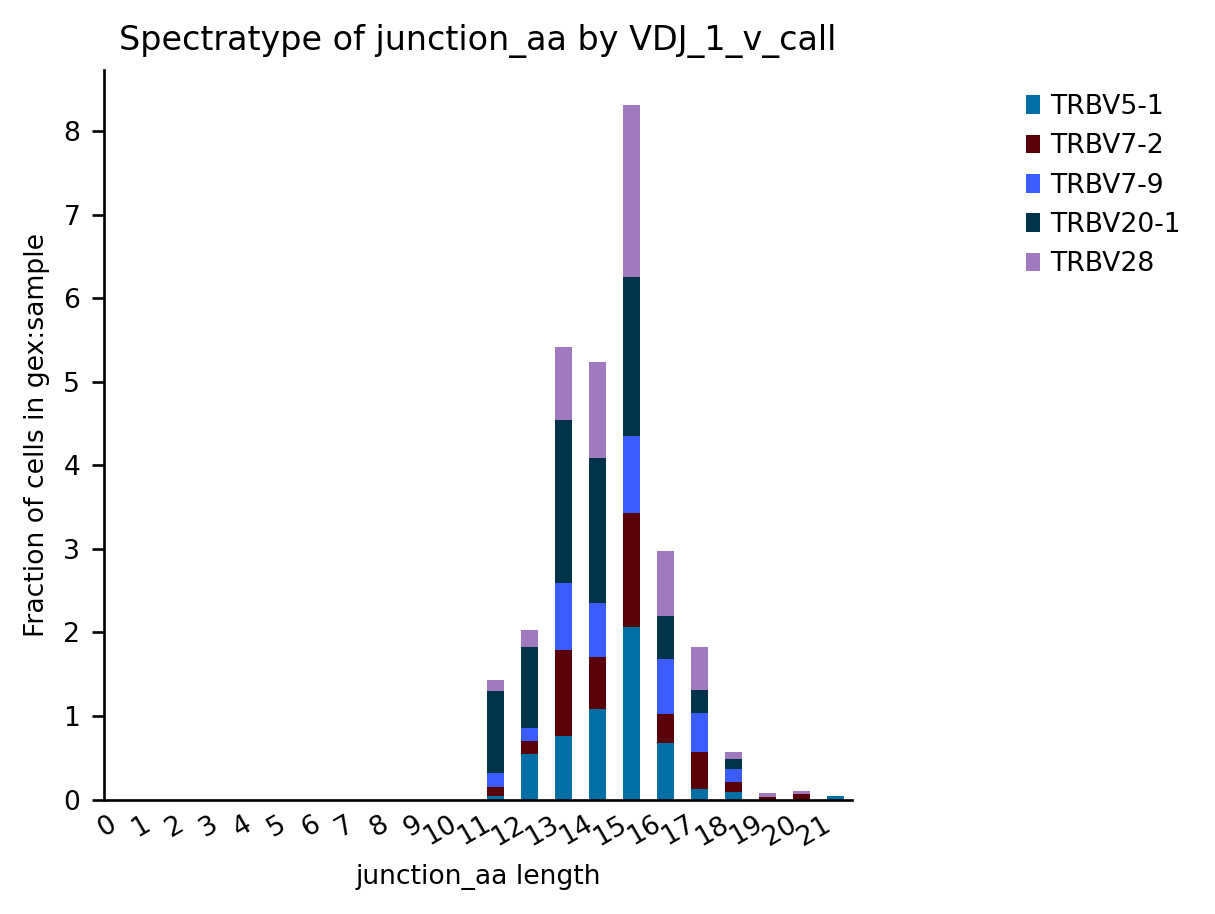

In [51]:
with ir.get.airr_context(mdata, "v_call"):
    ir.pl.spectratype(
        mdata[
            mdata.obs["VDJ_1_v_call"].isin(
                ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
            ),
            :,
        ],
        chain="VDJ_1",
        color="VDJ_1_v_call",
        normalize="gex:sample",
        fig_kws={"dpi": 120},
    )

## Comparing repertoires

### Repertoire simlarity and overlaps

In [52]:
df, dst, lk = ir.tl.repertoire_overlap(mdata, "gex:sample", inplace=False)
df.head()

clone_id      0    1    2    3    4    5    6    7    8    9  ...  1516  1517  \
gex:sample                                                    ...               
RN2         1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LN1         0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LN2         0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  3.0  ...   0.0   0.0   
LN4         0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   
LT6         0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   

clone_id    1518  1519  1520  1521  1522  1523  1524  1525  
gex:sample                                                  
RN2          0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
LN1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
LN2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
LN4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
LT6          1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  

[5 rows x 1526 columns]

The distance matrix can be shown as a heatmap, while samples are reordered based on hierarchical clustering.

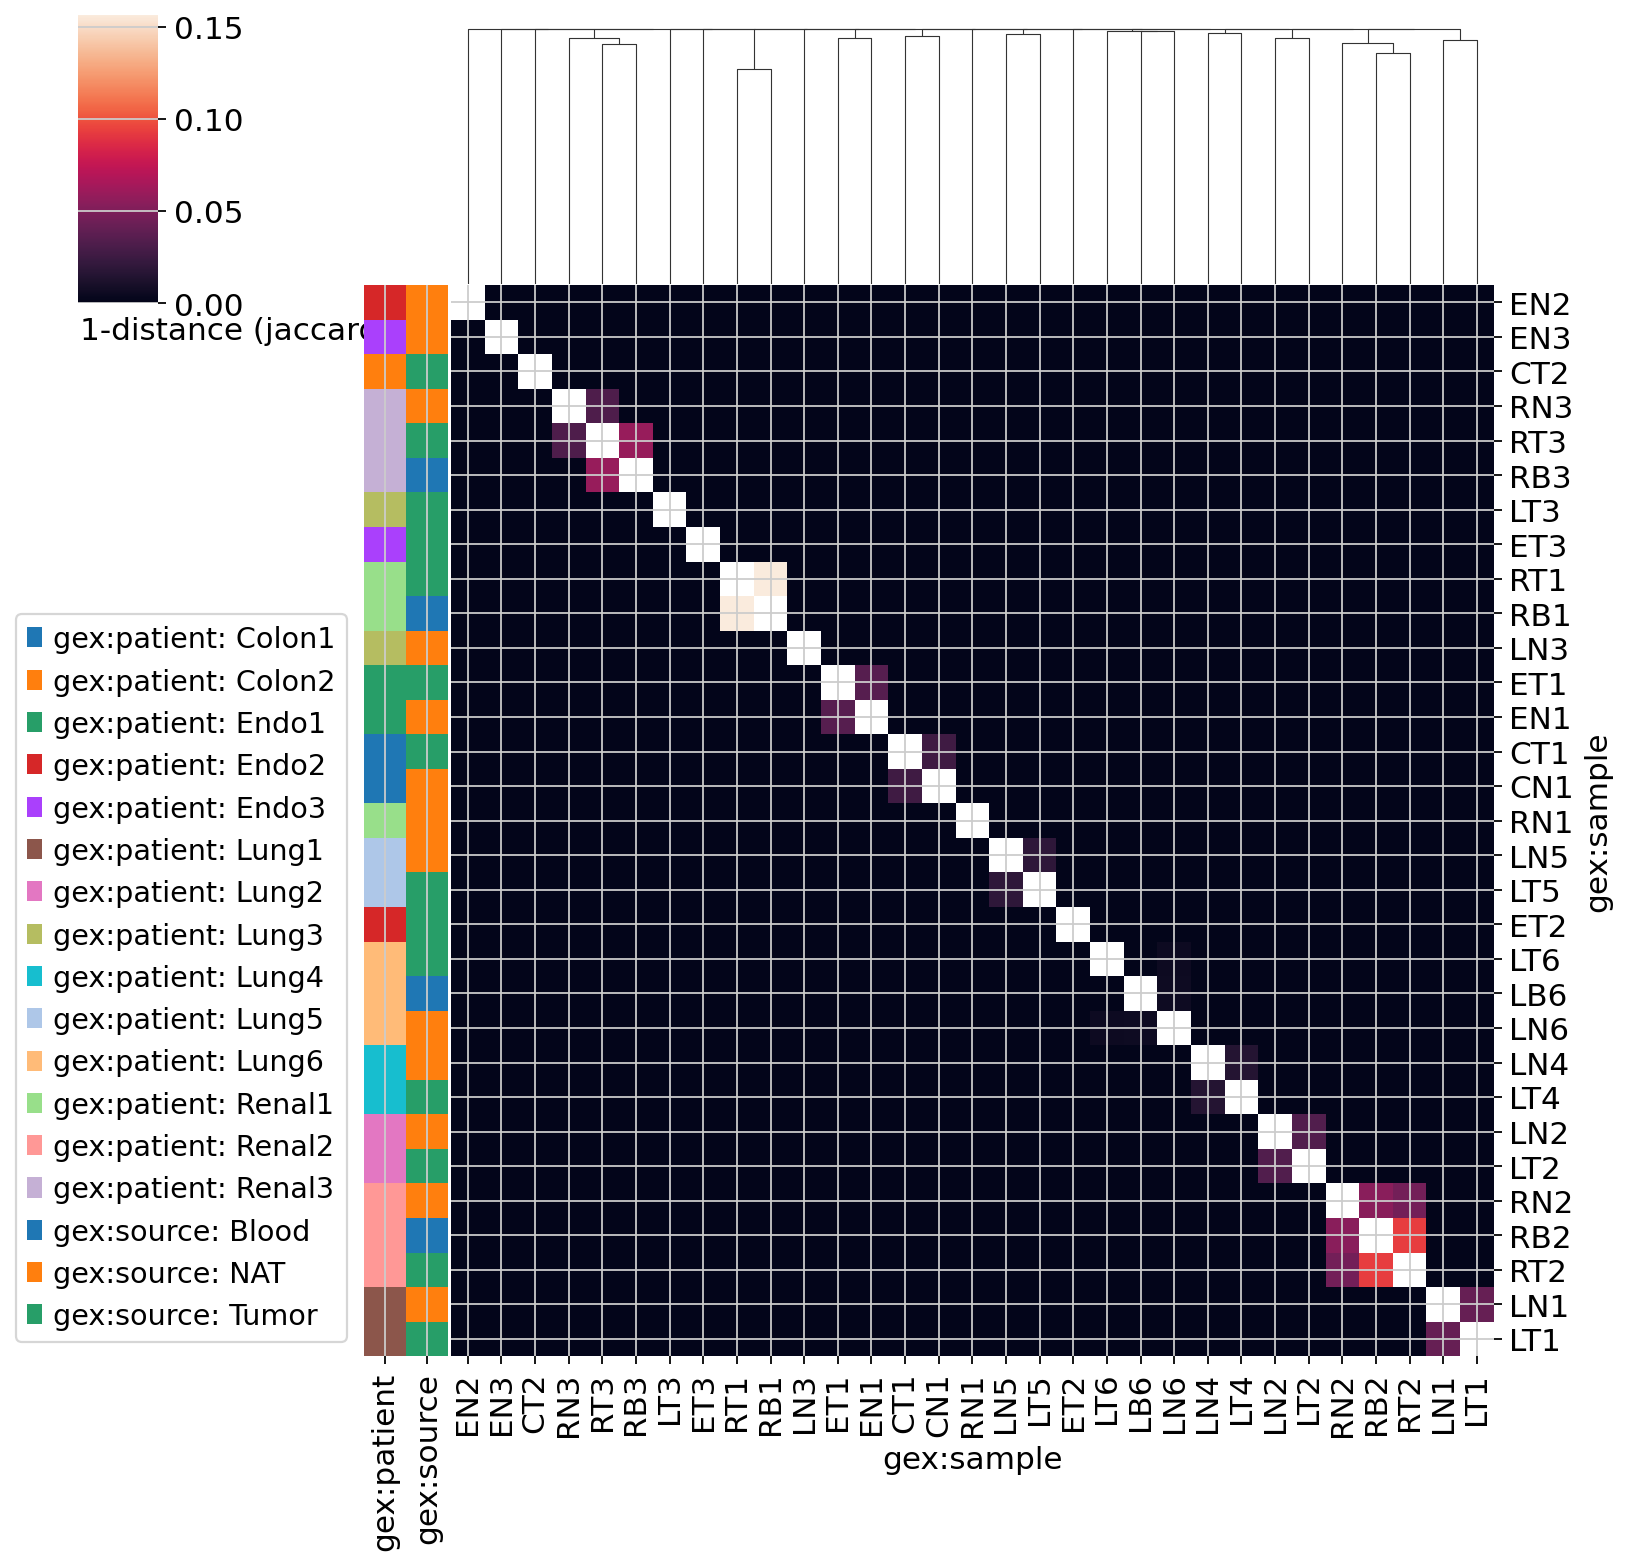

In [53]:
_ = ir.pl.repertoire_overlap(
    mdata,
    "gex:sample",
    heatmap_cats=["gex:patient", "gex:source"],
    yticklabels=True,
    xticklabels=True,
)

A specific pair of samples can be compared on a scatterplot, where dot size corresponds to the number of clonotypes at a given coordinate.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Repertoire overlap between LN2 and LT2'}, xlabel='Clonotype size in LN2', ylabel='Clonotype size in LT2'>

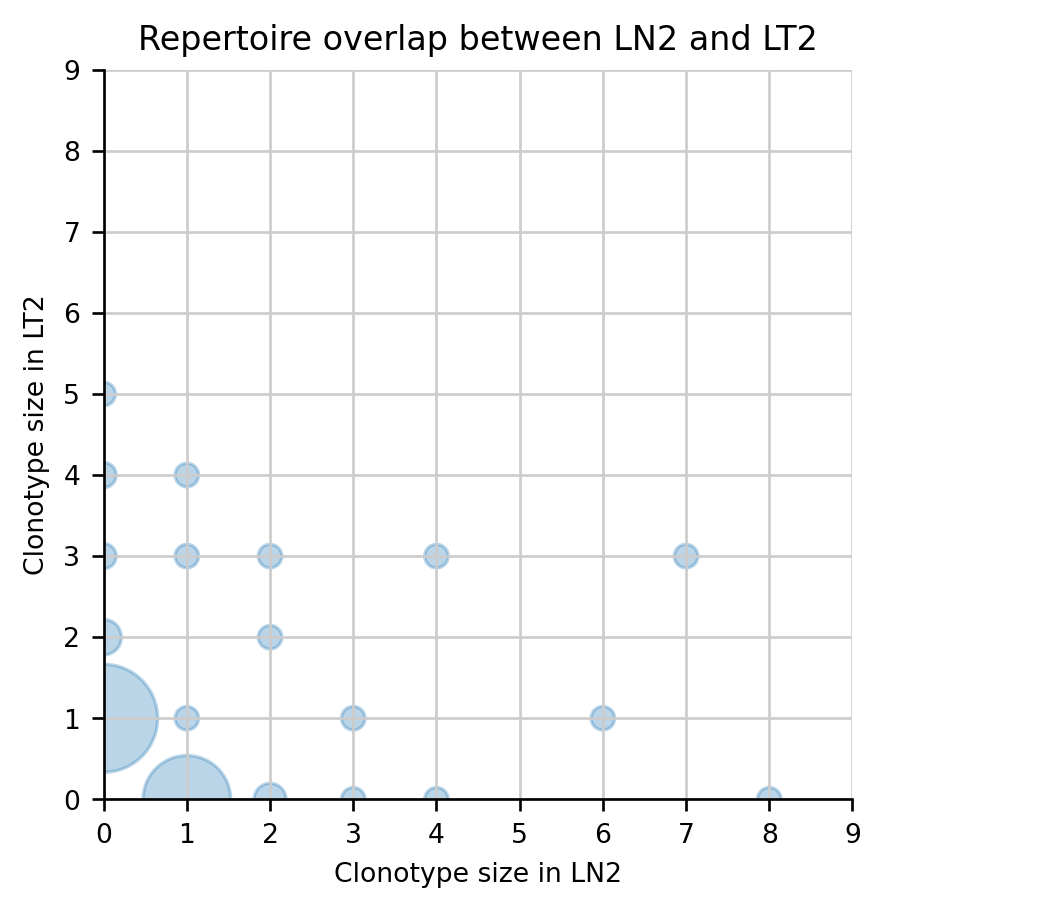

In [54]:
ir.pl.repertoire_overlap(
    mdata, "gex:sample", pair_to_plot=["LN2", "LT2"], fig_kws={"dpi": 120}
)

## Integrating gene expression data

Leveraging the opportunity offered by close integeration with scanpy, transcriptomics-based data can be utilized alongside immune receptor data.

### Clonotype modularity

In [55]:
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_alignment")

Initalizing clonotype subgraphs...


  0%|          | 0/1487 [00:00<?, ?it/s]

Computing background distributions...


  0%|          | 0/1000 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:clonotype_modularity"]`.
Stored result in `mdata.obs["airr:clonotype_modularity_fdr"]`.


We can plot the clonotype modularity on top of a umap of clonotype network plot

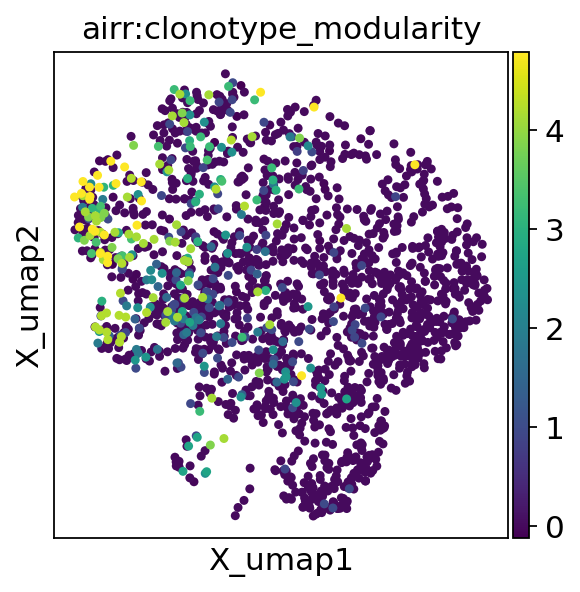

In [56]:
mu.pl.embedding(mdata, basis="gex:umap", color="airr:clonotype_modularity")

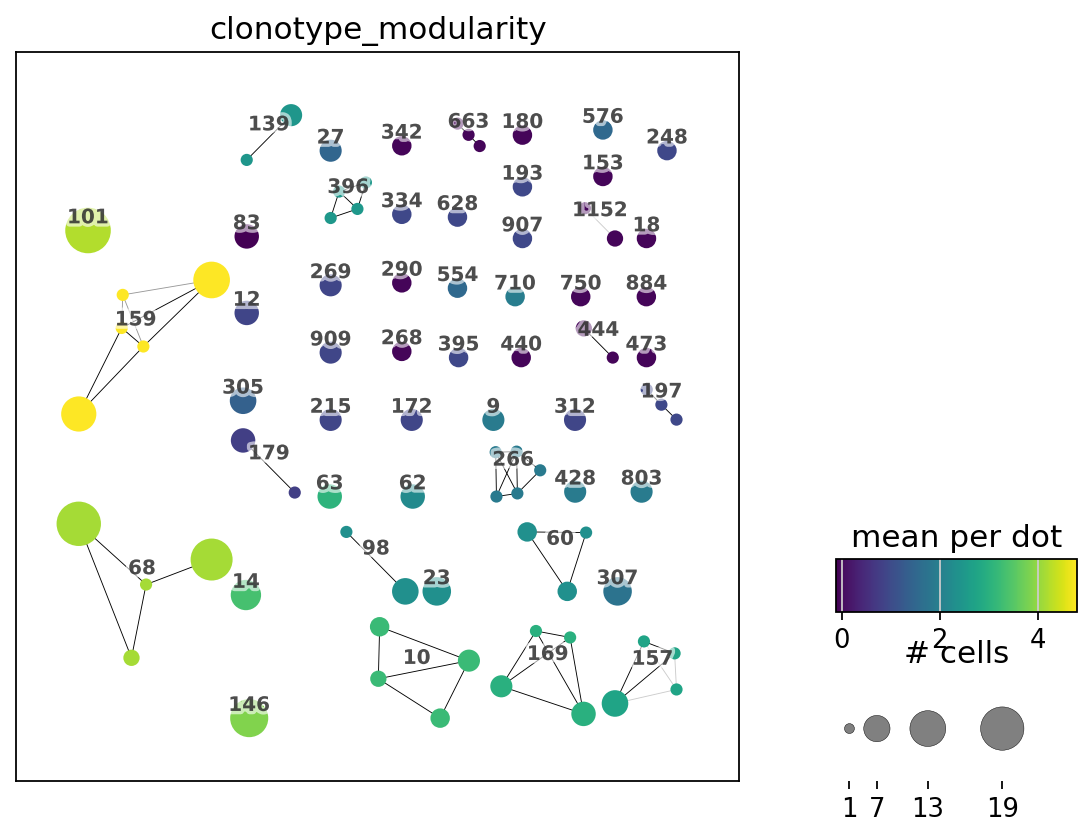

In [57]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=20,
)

We can also visualize the clonotype modularity together with the associated
FDR as a sort of "one sided volcano plot":

<Axes: xlabel='modularity score', ylabel='-log10(FDR)'>

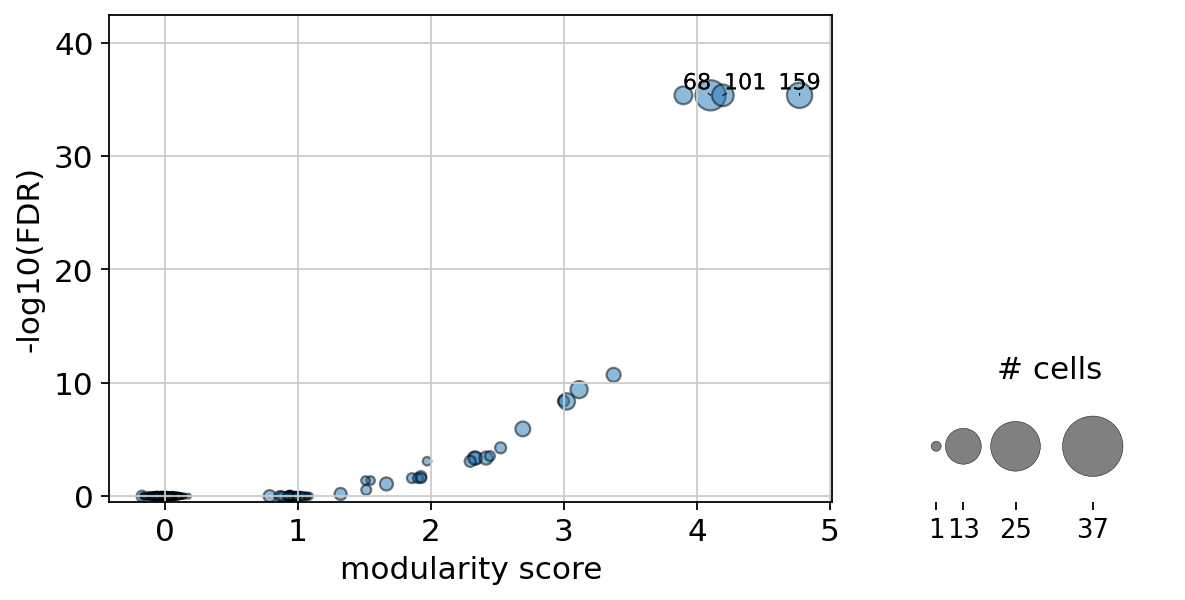

In [58]:
ir.pl.clonotype_modularity(mdata, base_size=20)

Let's further inspect the two top scoring candidates. We can extract that information from `mdata.obs["airr:clonotype_modularity"]`.

In [59]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_alignment")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:2]
)

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


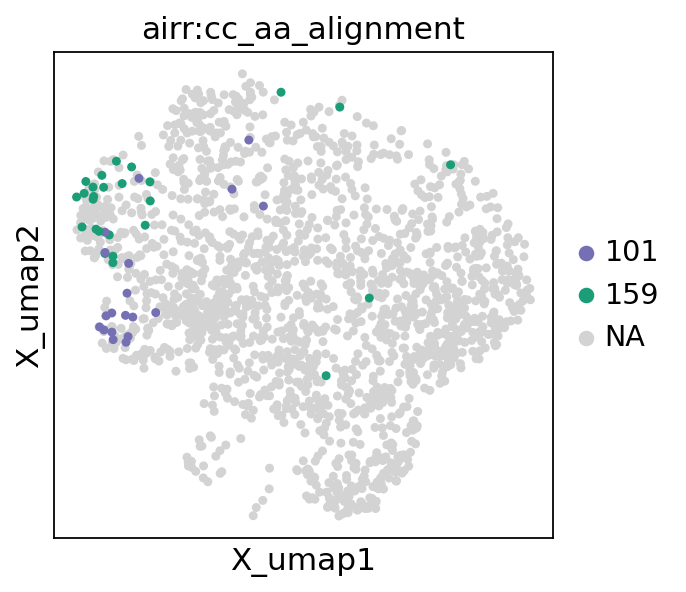

In [60]:
test_ad = mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:cc_aa_alignment",
    groups=clonotypes_top_modularity,
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

We observe that they are (mostly) restricted to a single cluster. By leveraging
scanpy's differential expression module, we can compare the gene expression
of the cells in the two clonotypes to the rest.

ranking genes
    finished (0:00:00)


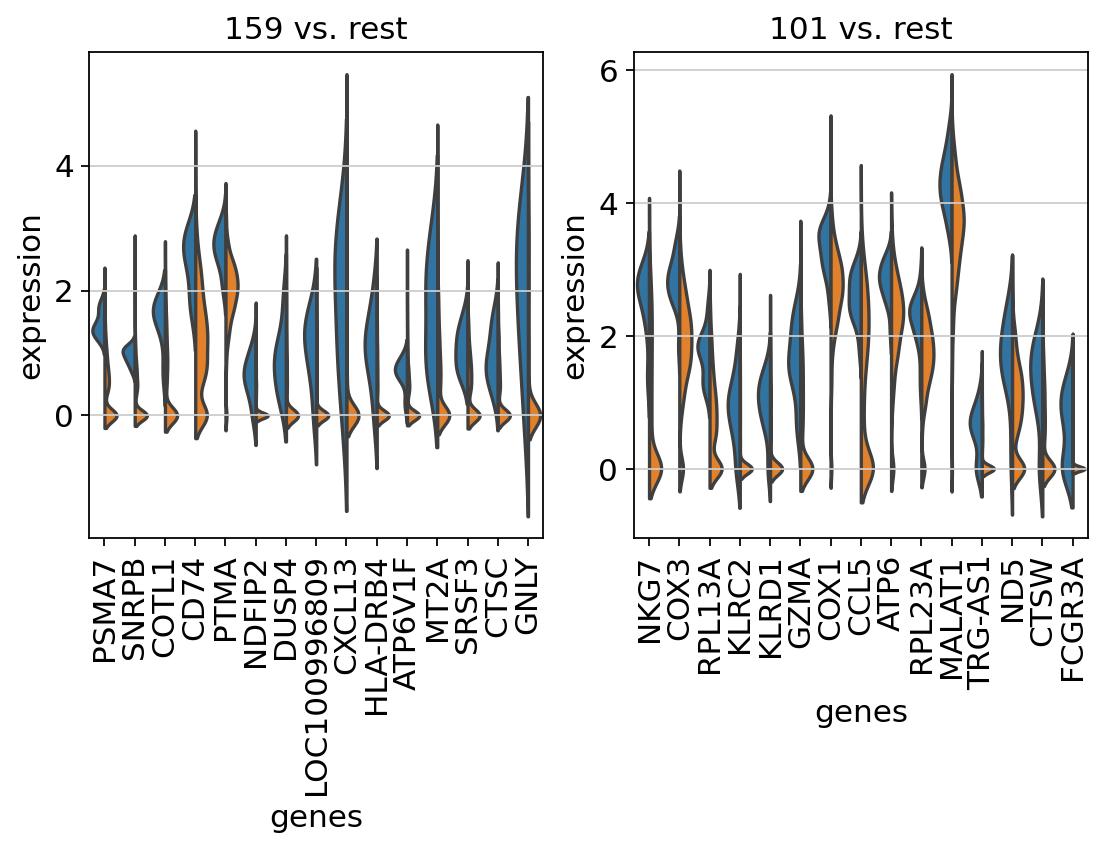

In [61]:
# Since sc.tl.rank_genes_group does not support MuData, we need to temporarily add
# the AIRR columns to the gene expression AnnData object
with ir.get.obs_context(
    mdata["gex"], {"clone_id": mdata.obs["airr:clone_id"]}
) as tmp_ad:
    sc.tl.rank_genes_groups(
        tmp_ad,
        "clone_id",
        groups=clonotypes_top_modularity,
        reference="rest",
        method="wilcoxon",
    )
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for ct, ax in zip(clonotypes_top_modularity, axs):
        sc.pl.rank_genes_groups_violin(
            tmp_ad, groups=[ct], n_genes=15, ax=ax, show=False, strip=False
        )

### Clonotype imbalance among cell clusters

Using cell type annotation inferred from gene expression clusters, for example, clonotypes belonging to CD8+ effector T-cells and CD8+ tissue-resident memory T cells, can be compared.

In [62]:
freq, stat = ir.tl.clonotype_imbalance(
    mdata,
    replicate_col="gex:sample",
    groupby="gex:cluster",
    case_label="CD8_Teff",
    control_label="CD8_Trm",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:3]

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scirpy/tl/_clonotype_imbalance.py:272: RuntimeWarning: divide by zero encountered in log2
  logfoldchange = np.log2((case_mean_freq + global_minimum) / (control_mean_freq + global_minimum))
/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scirpy/tl/_clonotype_imbalance.py:272: RuntimeWarning: divide by zero encountered in double_scalars
  logfoldchange = np.log2((case_mean_freq + global_minimum) / (control_mean_freq + global_minimum))


Showing top clonotypes on a UMAP clearly shows that clonotype 101 is featured by CD8+ tissue-resident memory T cells, while clonotype 68 by CD8+ effector and effector memory cells.

/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


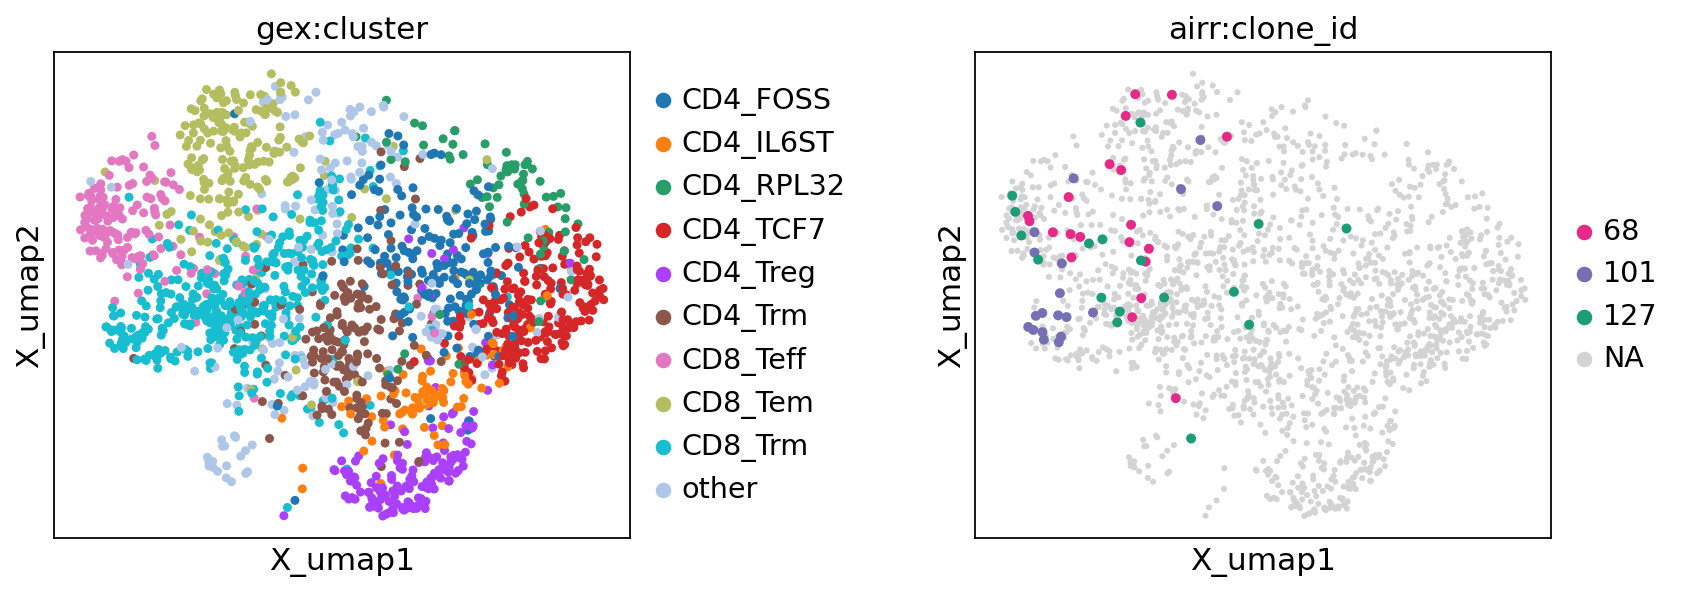

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
mu.pl.embedding(mdata, basis="gex:umap", color="gex:cluster", ax=ax1, show=False)
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color="airr:clone_id",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30
        for c in mdata.obs["airr:clone_id"][mdata.mod["gex"].obs_names]
    ],
    palette=cycler(color=mpl_cm.Dark2_r.colors),
)

### Repertoire overlap of cell types

Just like comparing repertoire overlap among samples, Scirpy also offers comparison between gene expression clusters or cell subpopulations. As an example, repertoire overlap of the two cell types compared above is shown.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


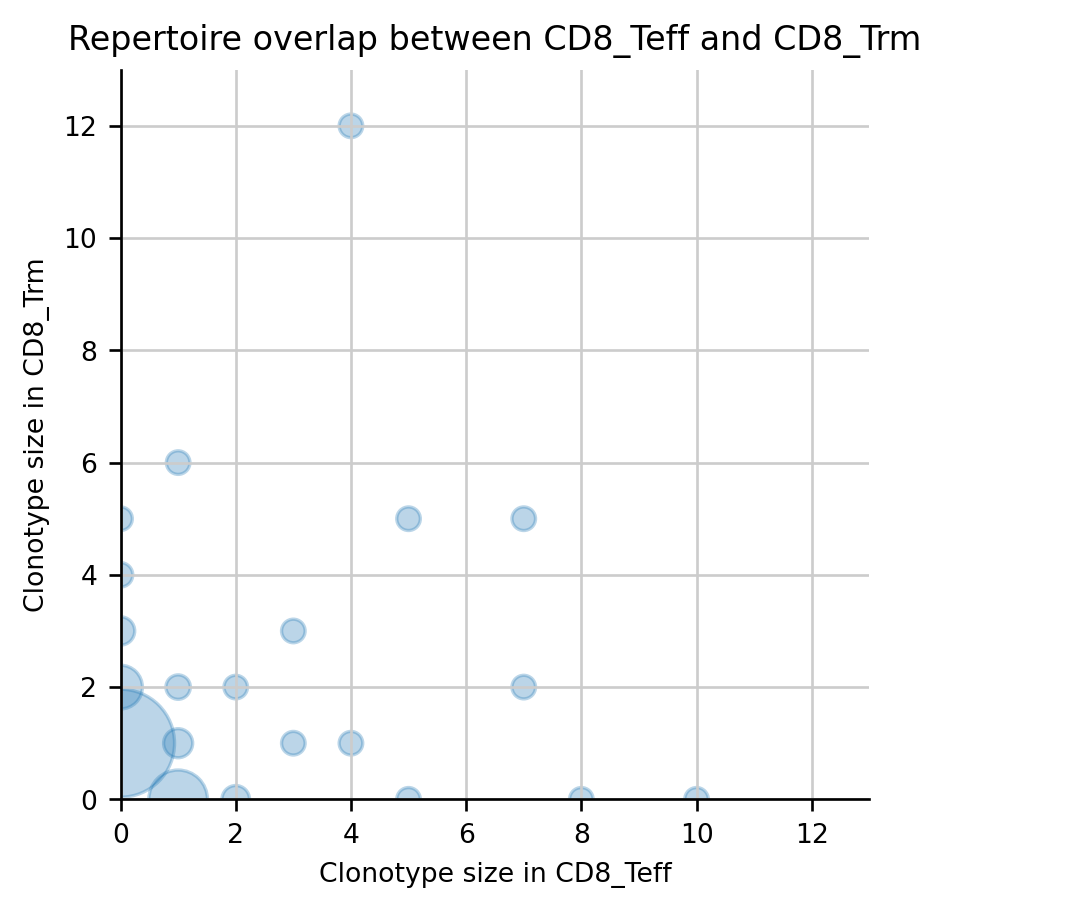

In [64]:
# ir.tl.repertoire_overlap(mdata, "gex:cluster")
_ = ir.pl.repertoire_overlap(
    mdata, "gex:cluster", pair_to_plot=["CD8_Teff", "CD8_Trm"], fig_kws={"dpi": 120}
)

### Marker genes in top clonotypes

Gene expression of cells belonging to individual clonotypes can also be compared using Scanpy. As an example, differential gene expression of two clonotypes, found to be specific to cell type clusters can also be analysed.

ranking genes
    finished (0:00:00)


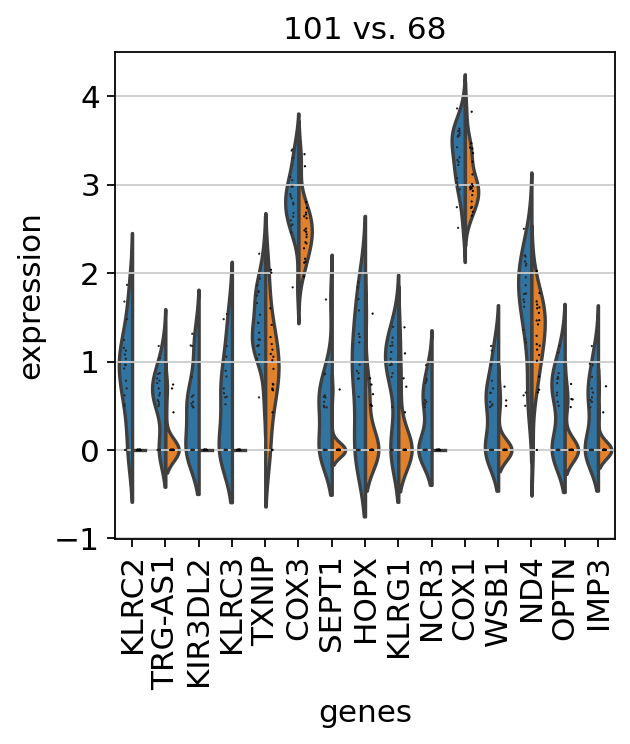

In [65]:
with ir.get.obs_context(
    mdata["gex"], {"clone_id": mdata.obs["airr:clone_id"]}
) as tmp_ad:
    sc.tl.rank_genes_groups(
        tmp_ad, "clone_id", groups=["101"], reference="68", method="wilcoxon"
    )
    sc.pl.rank_genes_groups_violin(tmp_ad, groups="101", n_genes=15)

## Query epitope databases

In [66]:
vdjdb = ir.datasets.vdjdb()

In [67]:
ir.pp.ir_dist(mdata, vdjdb, metric="identity", sequence="aa")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [68]:
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.


  0%|          | 0/1549 [00:00<?, ?it/s]

Stored IR distance matrix in `adata.uns["ir_query_VDJDB_aa_identity"]`.


In [69]:
ir.tl.ir_query_annotate_df(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene"],
).tail()

antigen.species antigen.gene
RT3_TCTCTAATCACAATGC-1             CMV          IE1
RT3_TCTCTAATCACAATGC-1             CMV          IE1
RT3_TCTCTAATCACAATGC-1             CMV          IE1
RT3_TCTCTAATCACAATGC-1      InfluenzaA           NP
RT3_TCTCTAATCACAATGC-1      SARS-CoV-2        ORF9b

In [70]:
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species"],
    strategy="most-frequent",
)

  0%|          | 0/315 [00:00<?, ?it/s]

Stored result in `mdata.obs["airr:antigen.species"]`.


/home/sturm/anaconda3/envs/scirpy_dev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


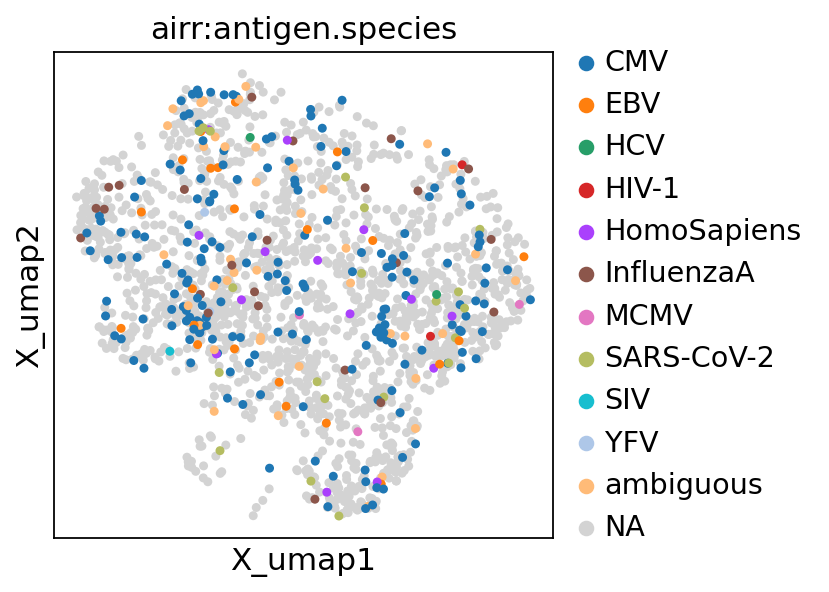

In [71]:
mu.pl.embedding(mdata, "gex:umap", color="airr:antigen.species")